In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import seaborn as sns
import time
from torchviz import make_dot, make_dot_from_trace
from skimage import io, transform
from torch import tensor
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from typing import List
from IPython.display import clear_output
import sys
sys.path.insert(0, '/home/caitao/Project/dl-localization')
from input_output import Default
from utility import Utility

# Common modules

In [2]:
class MinMaxNormalize:
    '''Min max normalization, the new bound is (lower, upper)
    '''
    def __init__(self, lower=0, upper=1):
        assert isinstance(lower, (int, float))
        assert isinstance(upper, (int, float))
        self.lower = lower
        self.upper = upper

    def __call__(self, matrix):
        minn = matrix.min()
        maxx = matrix.max()
        matrix = (matrix - minn) / (maxx - minn)
        if self.lower != 0 or self.upper != 1:
            matrix = self.lower + matrix * (self.upper - self.lower)
        return matrix.astype(np.float32)

class Metrics:
    '''Evaluation metrics
    '''
    @staticmethod
    def localization_error_image_continuous(pred_batch, pred_ntx, truth_batch, grid_len, debug=False):
        '''Continuous -- for single TX
           euclidian error when modeling the output representation is a matrix (image)
           both pred and truth are batches, typically a batch of 32
           now both prediction and truth are continuous numbers
        Args:
            pred_batch:  tensor -- size=(N, 1, 100, 100)
            truth_batch: tensor -- size=(N, num_tx, 2)
        '''
        eps = 1e-2
        errors = []
        for pred, pred_n, truth in zip(pred_batch, pred_ntx, truth_batch):
            # 1: get the multiple predicted locations
            pred = pred[0]           # there is only one channel
            pred_peaks, _ = Utility.detect_peak(pred, int(pred_n+eps))         # get the predictions 
            if debug:
                print('pred', pred_peaks)
                print('truth', truth)
            # 2: do a matching and get the error
            radius_threshold = Default.grid_length * Default.error_threshold
            error, miss, false = Utility.compute_error(pred_peaks, truth, radius_threshold, False)
            errors.extend(error)
            break
        return errors

# 2 Output is image, model as image translation problem

## Output representation is a grid (image)
## Use weighting to get a continuous output prediction

## Data

In [3]:
class SensorInputDatasetTranslation(Dataset):
    '''Sensor reading input dataset -- for multi TX
       Output is image, model as a image segmentation problem
    '''
    def __init__(self, root_dir: str, transform=None):
        '''
        Args:
            root_dir:  directory with all the images
            labels:    labels of images
            transform: optional transform to be applied on a sample
        '''
        self.root_dir = root_dir
        self.transform = transform
        self.length = len(os.listdir(self.root_dir))
        self.sample_per_label = self.get_sample_per_label()

    def __len__(self):
        return self.length * self.sample_per_label

    def __getitem__(self, idx):
        folder = int(idx/self.sample_per_label)
        folder = format(folder, '06d')
        matrix_name = str(idx%self.sample_per_label) + '.npy'
        matrix_path = os.path.join(self.root_dir, folder, matrix_name)
        target_name = str(idx%self.sample_per_label) + '.target.npy'
        target_img, target_float = self.get_translation_target(folder, target_name)
        matrix = np.load(matrix_path)
        if self.transform:
            matrix = self.transform(matrix)
        target_num = np.array([len(target_float)]).astype(np.float32)
        sample = {'matrix':matrix, 'target':target_img, 'target_float':target_float, 'target_num':target_num, 'index':idx}
        return sample

    def get_sample_per_label(self):
        folder = glob.glob(os.path.join(self.root_dir, '*'))[0]
        samples = glob.glob(os.path.join(folder, '*.npy'))
        targets = glob.glob(os.path.join(folder, '*.target.npy'))
        return len(samples) - len(targets)

    def get_translation_target(self, folder: str, target_name: str):
        '''
        Args:
            folder      -- eg. 000001
            target_name -- eg. 0.target.npy
        Return:
            np.ndarray, n = 2, the pixel with the TX is labeled 1, everywhere else is labeled 0
        '''
        location = np.load(os.path.join(self.root_dir, folder, target_name))
        num_tx = len(location)
        grid = np.zeros((Default.grid_length, Default.grid_length))
        for i in range(num_tx):
            x, y = location[i][0], location[i][1]
            target_float = (x, y)
            x, y = int(x), int(y)
            neighbor = []
            sum_weight = 0
            for i in [-1, 0, 1]:
                for j in [-1, 0, 1]:
                    nxt = (x + i, y + j)
                    if 0 <= nxt[0] < Default.grid_length and 0 <= nxt[1] < Default.grid_length:
                        weight = 1./Utility.distance((nxt[0] + 0.5, nxt[1] + 0.5), target_float)
                        sum_weight += weight
                        neighbor.append((nxt, weight))
            for n, w in neighbor:
                grid[n[0]][n[1]] = w / sum_weight * len(neighbor)
        grid = np.expand_dims(grid, 0)
        return grid.astype(np.float32), location.astype(np.float32)


tf = T.Compose([
     MinMaxNormalize(),
     T.ToTensor()
])

# training
i = 0
root_dir = './data/matrix-train30'
sensor_input_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_dataloader = DataLoader(sensor_input_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_dataset[i]['matrix'].shape)
print(sensor_input_dataset[i]['target'])
print(sensor_input_dataset[i]['target_float'])
print(sensor_input_dataset.__len__())

# testing
root_dir = './data/matrix-test30'
sensor_input_test_dataset = SensorInputDatasetTranslation(root_dir = root_dir, transform = tf)
sensor_input_test_dataloader = DataLoader(sensor_input_test_dataset, batch_size=32, shuffle=True, num_workers=3)
print(sensor_input_test_dataset[i]['matrix'].dtype)
print(sensor_input_test_dataset[i]['target'].dtype)
print(sensor_input_test_dataset[i]['target_float'].shape)
print(sensor_input_test_dataset[i]['target_num'].shape)
print(sensor_input_test_dataset.__len__())

torch.Size([1, 100, 100])
[[[2.2074277  0.53392583 0.         ... 0.         0.         0.        ]
  [0.8044668  0.45417964 0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
[[ 0.7523271  0.3895659]
 [48.994858  64.993996 ]]
100000
torch.float32
float32
(2, 2)
(1,)
20000


In [4]:
print(sensor_input_dataset[0]['target_float'])
print(sensor_input_dataset[0]['target'][0][46:51, 62:67])

[[ 0.7523271  0.3895659]
 [48.994858  64.993996 ]]
[[0.        0.        0.        0.        0.       ]
 [0.        0.4912577 0.6594669 0.6578752 0.       ]
 [0.        0.6596964 1.4848477 1.4669416 0.       ]
 [0.        0.6583311 1.4694728 1.4521108 0.       ]
 [0.        0.        0.        0.        0.       ]]


## Model

In [4]:
class NetTranslation2(nn.Module):
    '''Image translation. comparing to NetTranslation, this model is composed of TWO CNNs
       the first CNN is the same as NetTranslation, the second one uses the output of the first CNN and output the # of TX
       this # of TX will help the peak finding and hope reduce the localization error and cardinality error.
       Assuming the input image is 1 x 100 x 100
    '''
    def __init__(self):
        super(NetTranslation2, self).__init__()
        self.conv11 = nn.Conv2d(1, 8, 5, padding=2)
        self.conv12 = nn.Conv2d(8, 32, 5, padding=2)
        self.conv13 = nn.Conv2d(32, 1, 5, padding=2)
        self.conv21 = nn.Conv2d(1, 2, 5)
        self.conv22 = nn.Conv2d(2, 4, 5)
        self.conv23 = nn.Conv2d(4, 8, 5)
        self.groupnorm1 = nn.GroupNorm(1, 2)
        self.groupnorm2 = nn.GroupNorm(2, 4)
        self.groupnorm3 = nn.GroupNorm(4, 8)
        self.fc1 = nn.Linear(648, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # first CNN input is 1 x 100 x 100
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        y1 = self.conv13(x)
        # second CNN takes in y1, which is also 1 x 100 x 100
        x = F.max_pool2d(F.relu(self.groupnorm1(self.conv21(y1))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm2(self.conv22(x))), 2)
        x = F.max_pool2d(F.relu(self.groupnorm3(self.conv23(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        y2 = self.fc2(x)
        return y1, y2

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = NetTranslation2()
print(net)

NetTranslation2(
  (conv11): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv12): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv13): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv21): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv22): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv23): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (groupnorm1): GroupNorm(1, 2, eps=1e-05, affine=True)
  (groupnorm2): GroupNorm(2, 4, eps=1e-05, affine=True)
  (groupnorm3): GroupNorm(4, 8, eps=1e-05, affine=True)
  (fc1): Linear(in_features=648, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


# Visualize

In [9]:
X = sensor_input_test_dataset[0]['matrix']
X = tensor(np.expand_dims(X, 0)).to(device)
pred_matrix, pred_ntx = net(X)

NameError: name 'device' is not defined

In [9]:
make_dot(pred_matrix, params=dict(list(net.named_parameters())))

NameError: name 'pred_matrix' is not defined

## Loss is nn.MSELoss()

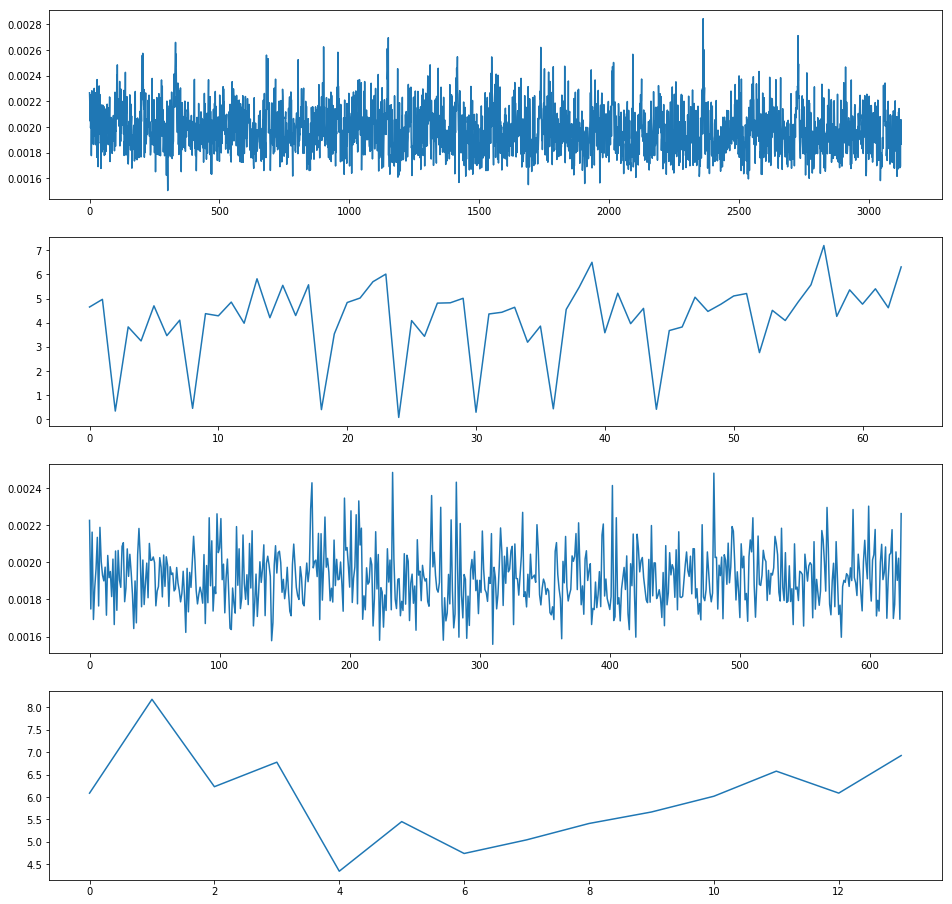

train loss mean = 0.001975726034529507
train loss std  = 0.00017539725280229043
test  loss mean = 0.0019185491614043713
test  loss std  = 0.00015766139046402092
train mean = 4.1814959610346705
train std  = 1.5700034096279312
test mean = 5.965630326952253
test std  = 0.9477867276138532
train loss
(0.0047543250128626825, 0.052627898296310115)
(0.002491520832106471, 0.00018935689736075407)
(0.0022613895437493922, 0.00019199717251736718)
(0.0020693086171150207, 0.00019816437596783124)
(0.001975726034529507, 0.00017539725280229043)
train error
(0.7156269117258489, 1.062063409962575)
(4.653758310130797, 2.019155097545703)
(4.77395565668121, 1.422378272451911)
(4.371770450845361, 1.47334716810695)
(4.1814959610346705, 1.5700034096279312)
test loss
(0.002629000099375844, 0.0001551229290150446)
(0.002665430448949337, 0.00016119497841200588)
(0.002113265206851065, 0.00015975791974735798)
(0.0020924216667190195, 0.00016423571325409754)
(0.0019185491614043713, 0.00015766139046402092)
test error
(4

In [5]:
# %%time
# image translation problem

net = NetTranslation2()

device    = torch.device('cuda')
model     = net.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion1 = nn.MSELoss()  # criterion is the loss function
criterion2 = nn.MSELoss()   # latter change this to MSELoss and see what happens

num_epochs = 5
train_losses_epoch = []
train_errors_epoch = []
test_errors_epoch  = []
test_losses_epoch    = []
print_every = 500
error_every = 100

for epoch in range(num_epochs):
    print(f'epoch = {epoch}')
    train_losses = []
    train_errors = []
    test_losses  = []
    test_errors  = []
    model.train()
    for t, sample in enumerate(sensor_input_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_float = sample['target_float']
        pred_matrix, pred_ntx = model(X)              # the model
        loss_matrix = criterion1(pred_matrix, y)
        loss_num_tx = criterion2(pred_ntx, y_num)
        loss = loss_matrix + loss_num_tx
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        pred_matrix = pred_matrix.data.cpu()
        if t % error_every == 0:
            train_errors.extend(Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, Default.grid_length))
        if t % print_every == 0:
            print(f't = {t}, loss_matrix = {loss_matrix.item()}, loss_num_tx = {loss_num_tx.item()}')

    model.eval()
    for t, sample in enumerate(sensor_input_test_dataloader):
        X = sample['matrix'].to(device)
        y = sample['target'].to(device)
        y_num   = sample['target_num'].to(device)
        y_float = sample['target_float']
        pred_matrix, pred_ntx = model(X)               # the model
        loss_matrix = criterion1(pred_matrix, y)
        loss_num_tx = criterion2(pred_ntx, y_num)
        loss = loss_matrix + loss_num_tx
        test_losses.append(loss.item())
        pred_matrix = pred_matrix.data.cpu()
        if t % error_every == 0:
            test_errors.extend(Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_float, Default.grid_length))
    
    clear_output(True)
    plt.figure(figsize=(16, 16))
    plt.subplot(411)
    plt.plot(train_losses)
    plt.subplot(412)
    plt.plot(train_errors)
    plt.subplot(413)
    plt.plot(test_losses)
    plt.subplot(414)
    plt.plot(test_errors)
    plt.show()
    
    print('train loss mean =', np.mean(train_losses))
    print('train loss std  =', np.std(train_losses))
    print('test  loss mean =', np.mean(test_losses))
    print('test  loss std  =', np.std(test_losses))
    print('train mean =', np.mean(train_errors))
    print('train std  =', np.std(train_errors))    
    print('test mean =', np.mean(test_errors))
    print('test std  =', np.std(test_errors))
    train_losses_epoch.append((np.mean(train_losses), np.std(train_losses)))
    train_errors_epoch.append((np.mean(train_errors), np.std(train_errors)))
    test_losses_epoch.append((np.mean(test_losses), np.std(test_losses)))
    test_errors_epoch.append((np.mean(test_errors), np.std(test_errors)))
    

print('train loss')
for loss in train_losses_epoch:
    print(loss)
print('train error')
for error in train_errors_epoch:
    print(error)
print('test loss')
for loss in test_losses_epoch:
    print(loss)
print('test error')
for error in test_errors_epoch:
    print(error)

In [16]:
def myplot(X, pred, y, indx, i):
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    sns.heatmap(X[0], cmap='gray', annot=False, ax=axs[0])
    sns.heatmap(pred[0], cmap='gray', annot=False, ax=axs[1])
    sns.heatmap(y[0], cmap='gray', annot=False, ax=axs[2])
    axs[0].set_title(f'{indx} - {i}')
    fig.tight_layout()

def myplot2(pred, y, y_float):
    print(y_float)
    fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'pred {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(pred[0][a1:a2,b1:b2], cmap='gray', annot=True, ax=axs[i])
        axs[i].set_title(f'pred {i} ({a}, {b})')
    for i in range(len(y_float)):
        a, b = y_float[i]
        a, b = int(a), int(b)
        a1 = a-5 if a >= 5 else 0
        a2 = a+5 if a <= Default.grid_length-5 else Default.grid_length
        b1 = b-5 if b >= 5 else 0
        b2 = b+5 if b <= Default.grid_length-5 else Default.grid_length
        print(f'y    {i} ({a1}, {a2}), ({b1}, {b2})')
        sns.heatmap(y[0][a1:a2, b1:b2], cmap='gray', annot=True, ax=axs[i+2])
        axs[i+2].set_title(f'y   {i} ({a}, {b})')
    fig.tight_layout()

In [61]:
Metrics.localization_error_image_continuous(pred_matrix, pred_ntx, y_f, Default.grid_length, True)

pred [(20, 91), (93, 59)]
truth tensor([[19.9550, 92.3005],
        [93.8431, 59.6703]])


[1.0770740509033203, 1.301292061805725]

tensor([[19.9550, 92.3005],
        [93.8431, 59.6703]])


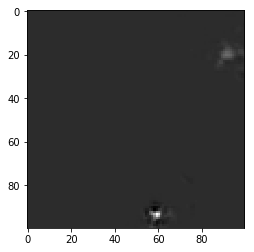

In [49]:
plt.imshow(pred_matrix[0][0], cmap='gray')
np.savetxt('test.txt', pred_matrix[0][0])
print(y_f[0])

In [64]:
model.eval()
for t, sample in enumerate(sensor_input_test_dataloader):
    X = sample['matrix'].to(device)
    y = sample['target'].to(device)
    y_ntx = sample['target_num']
    y_f = sample['target_float']
    indx = sample['index']
    pred_matrix, pred_ntx = model(X)
    errors = Metrics.localization_error_image_continuous(pred_matrix.data.cpu().numpy(), pred_ntx.data.cpu().numpy(), y_f, Default.grid_length, False)
    print(np.mean(errors), np.std(errors))
    break

X    = X.data.cpu().numpy()
pred_matrix = pred_matrix.data.cpu().numpy()
y    = y.data.cpu().numpy()
pred_ntx = pred_ntx.data.cpu().numpy()
indx = sample['index']
for pred_nt, y_nt in zip(pred_ntx, y_ntx):
    print(pred_nt, y_nt)

2.27130925655365 0.00036895275115966797
[2.0000818] tensor([2.])
[2.000102] tensor([2.])
[2.0000632] tensor([2.])
[2.0000608] tensor([2.])
[2.0000668] tensor([2.])
[2.0000713] tensor([2.])
[2.000101] tensor([2.])
[2.0000463] tensor([2.])
[2.000086] tensor([2.])
[2.0000634] tensor([2.])
[2.0000713] tensor([2.])
[2.000075] tensor([2.])
[2.0000606] tensor([2.])
[2.000087] tensor([2.])
[2.0000775] tensor([2.])
[2.000064] tensor([2.])
[2.0000648] tensor([2.])
[2.000084] tensor([2.])
[2.0000792] tensor([2.])
[2.0000565] tensor([2.])
[2.000075] tensor([2.])
[2.0000782] tensor([2.])
[2.0000894] tensor([2.])
[2.000067] tensor([2.])
[2.0000517] tensor([2.])
[2.000053] tensor([2.])
[2.0000687] tensor([2.])
[2.0000627] tensor([2.])
[2.0000648] tensor([2.])
[2.000066] tensor([2.])
[2.0000684] tensor([2.])
[2.0000973] tensor([2.])


tensor([[17.5649, 74.7017],
        [63.0030,  6.6763]])
pred 0 (12, 22), (69, 79)
pred 1 (58, 68), (1, 11)
y    0 (12, 22), (69, 79)
y    1 (58, 68), (1, 11)


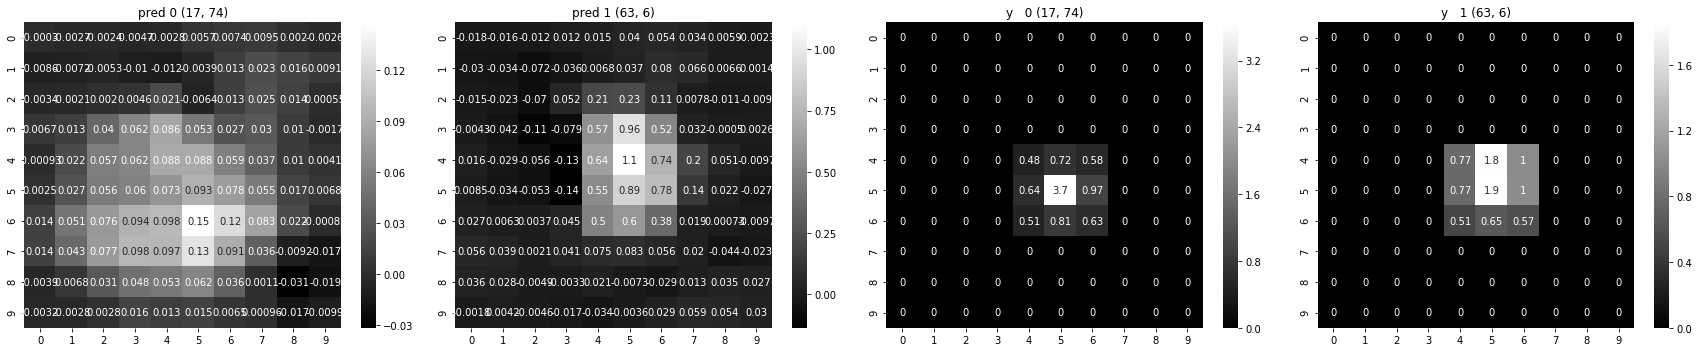

In [37]:
i = 0
myplot2(pred_matrix[i], y[i], y_f[i])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

/home/caitao/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


20 21 22 23 24 25 26 27 28 29 30 31 

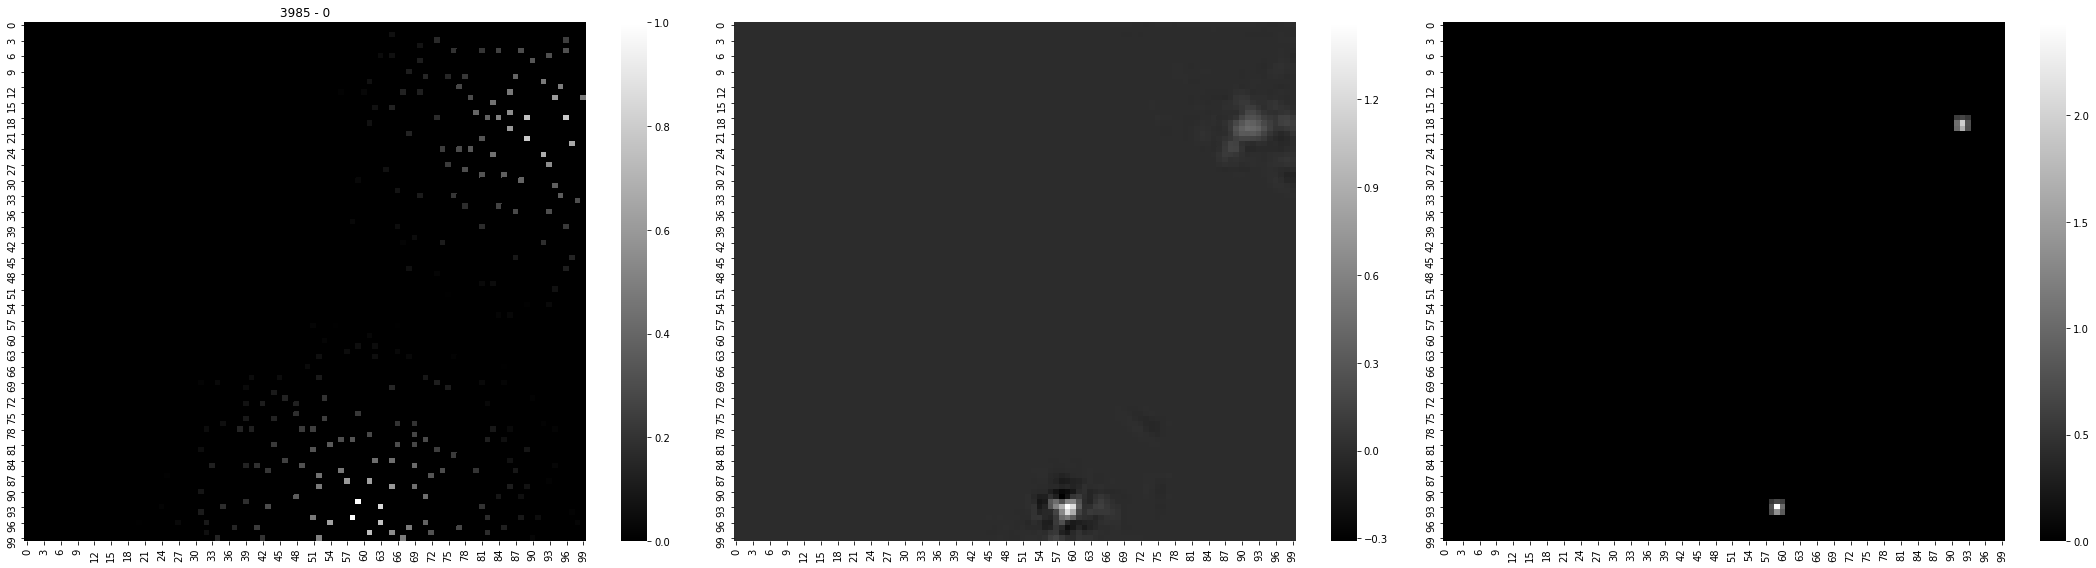

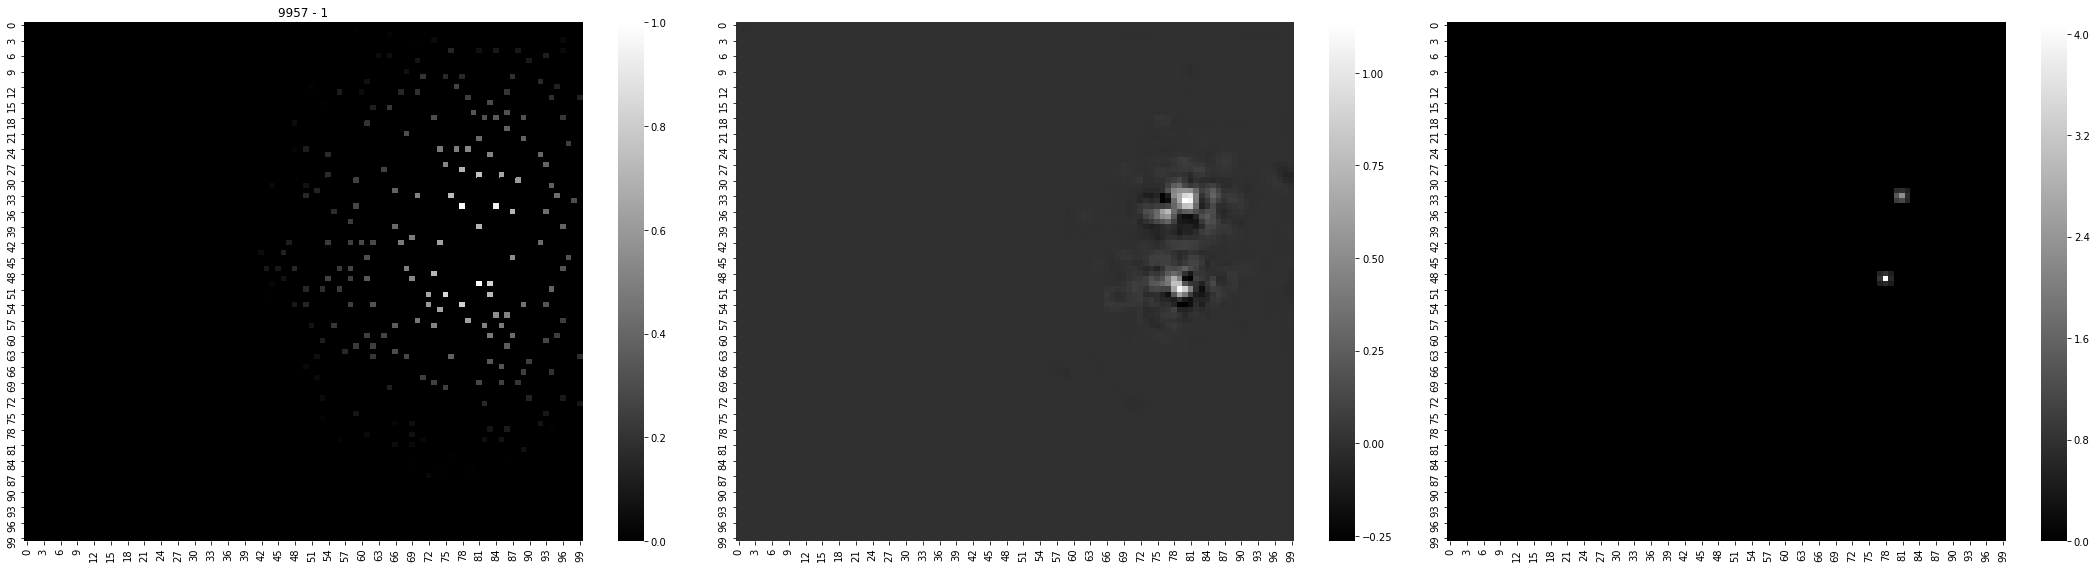

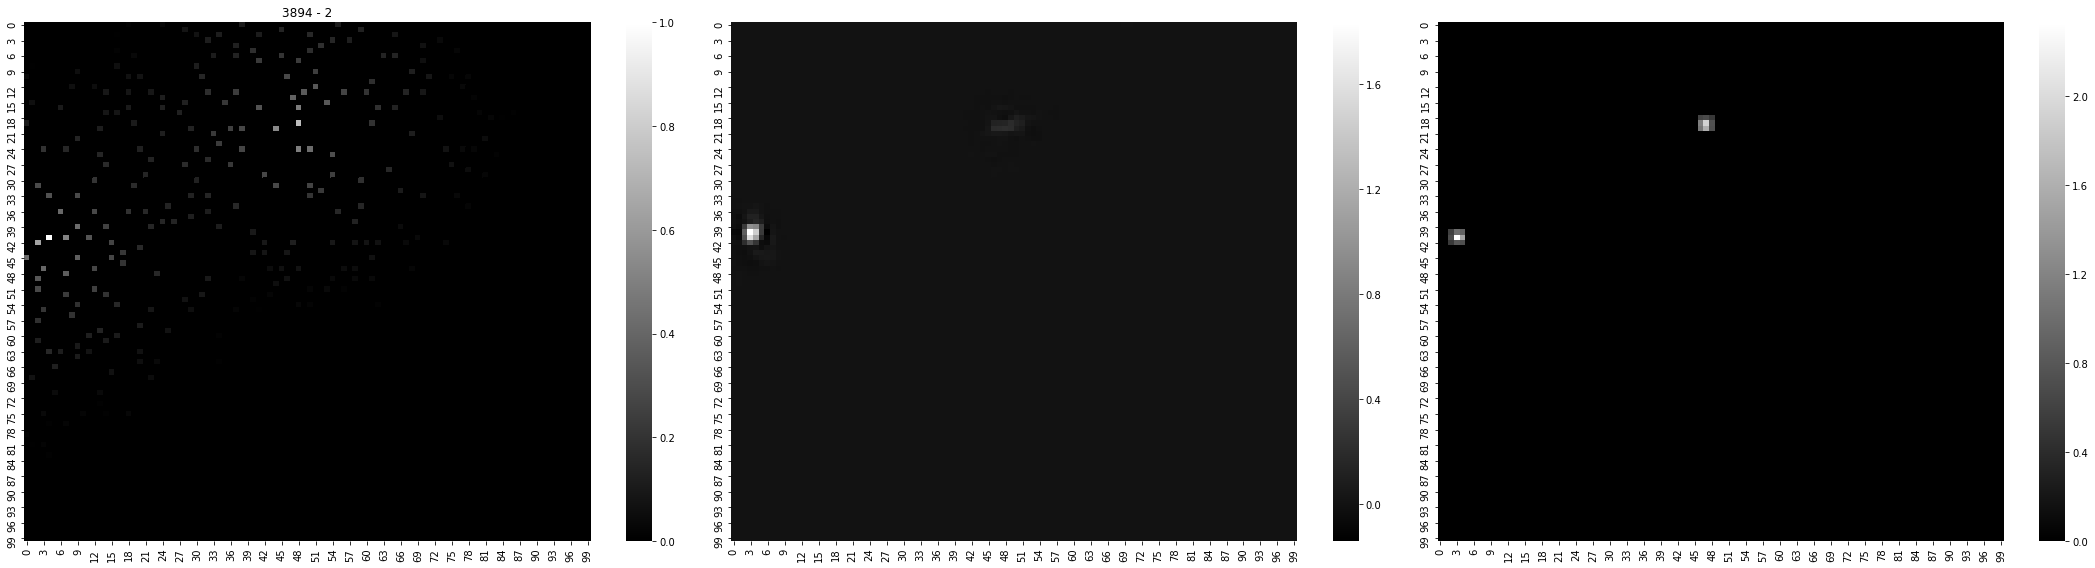

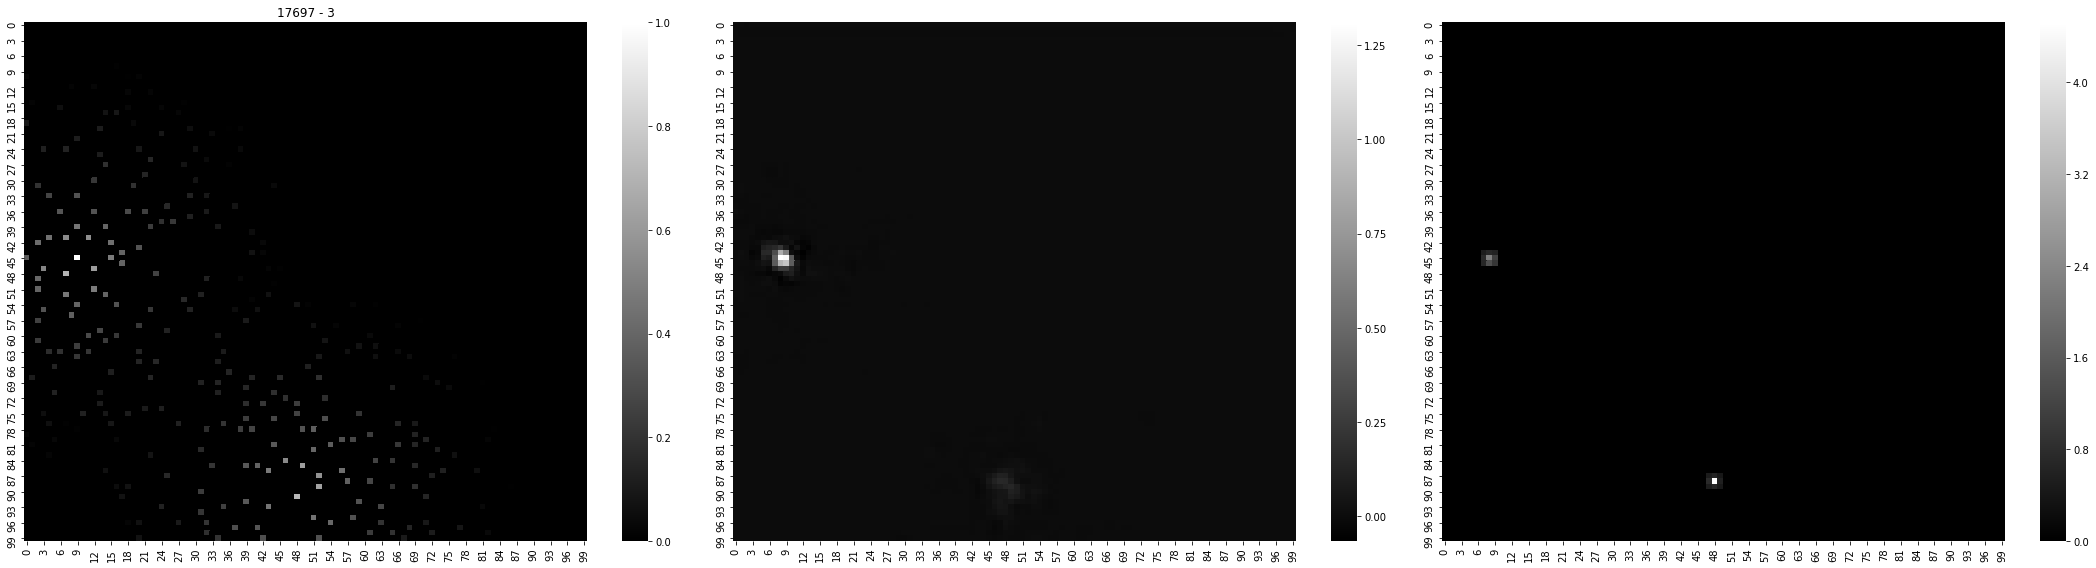

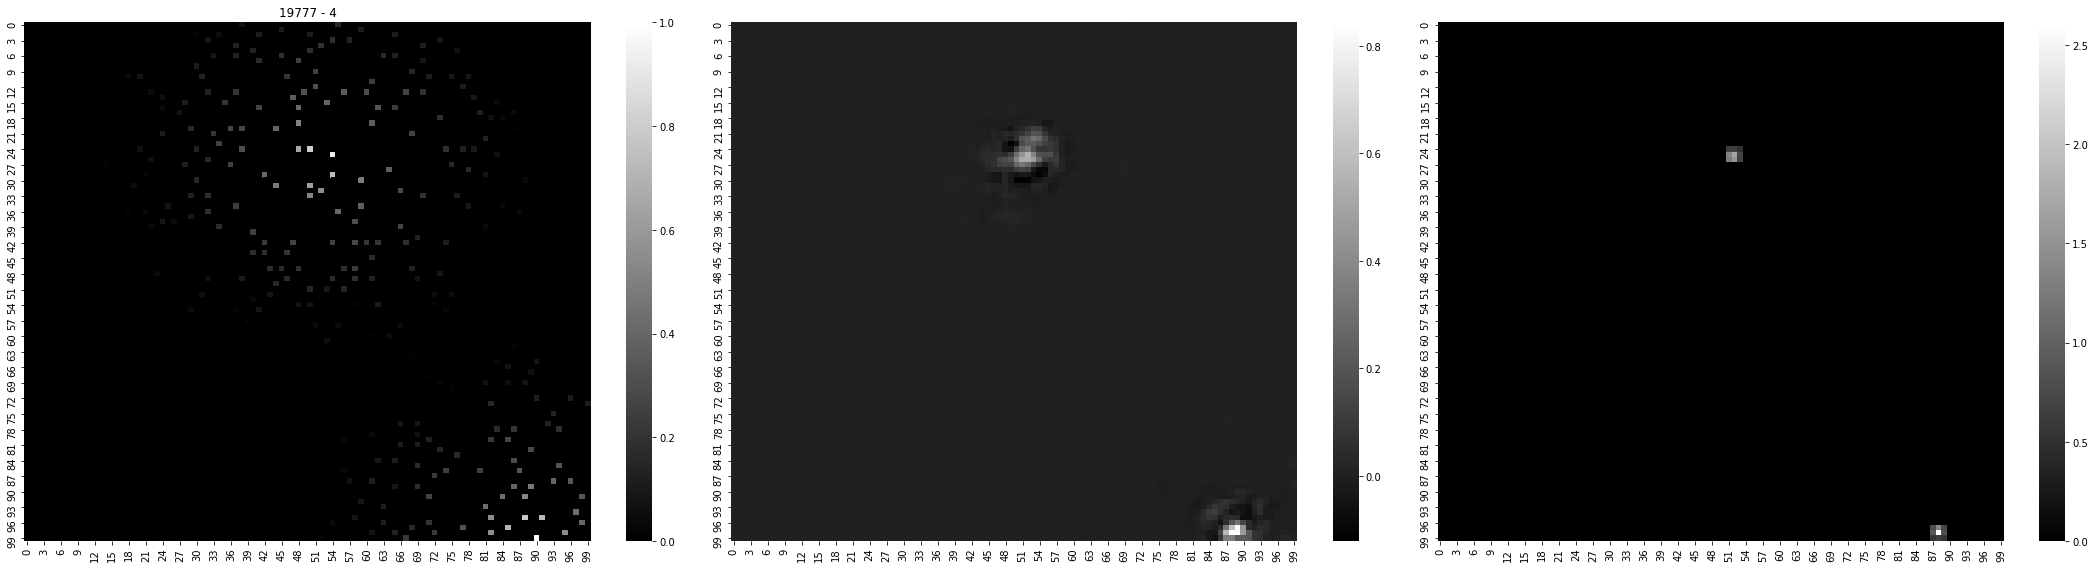

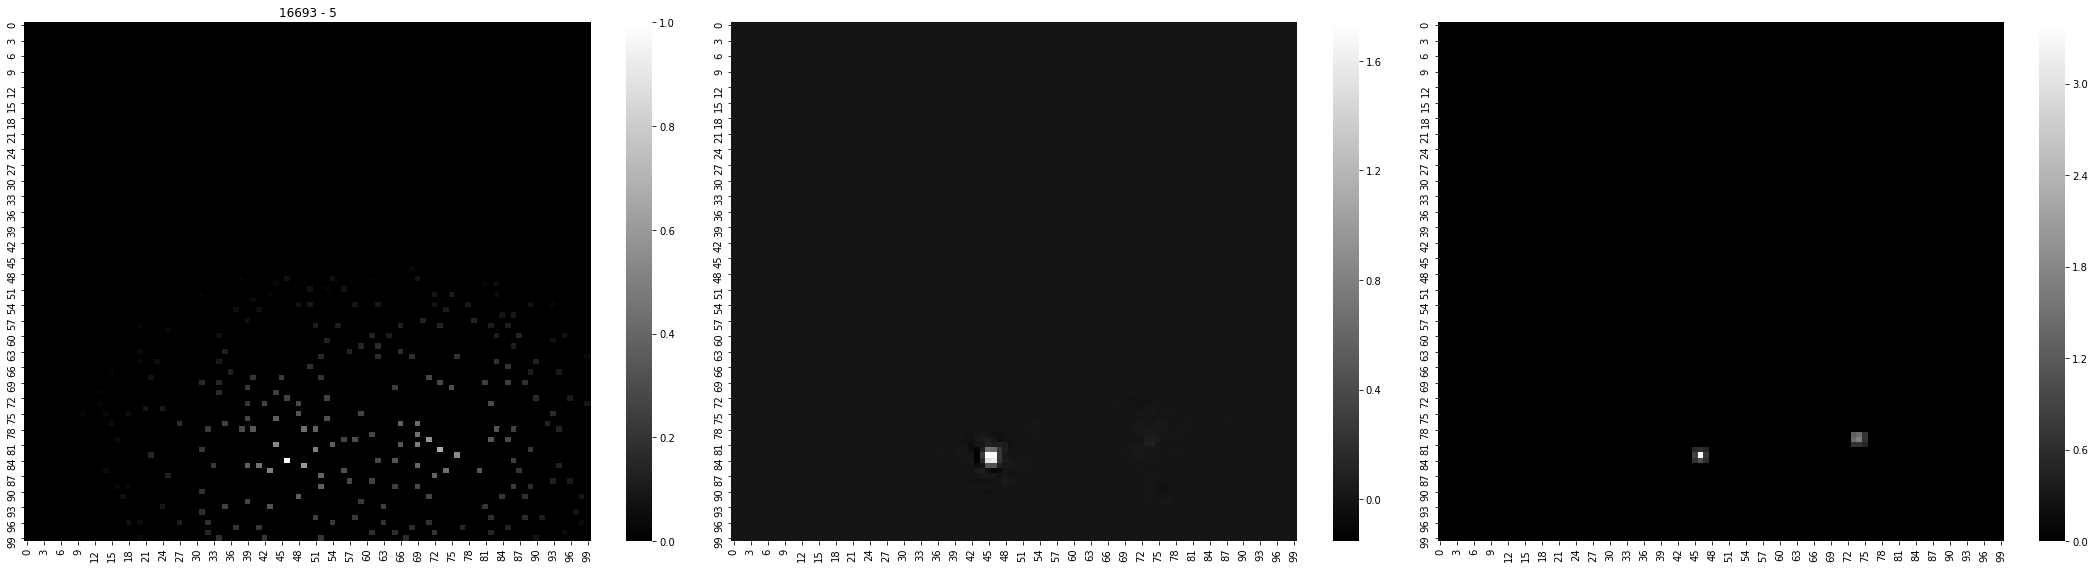

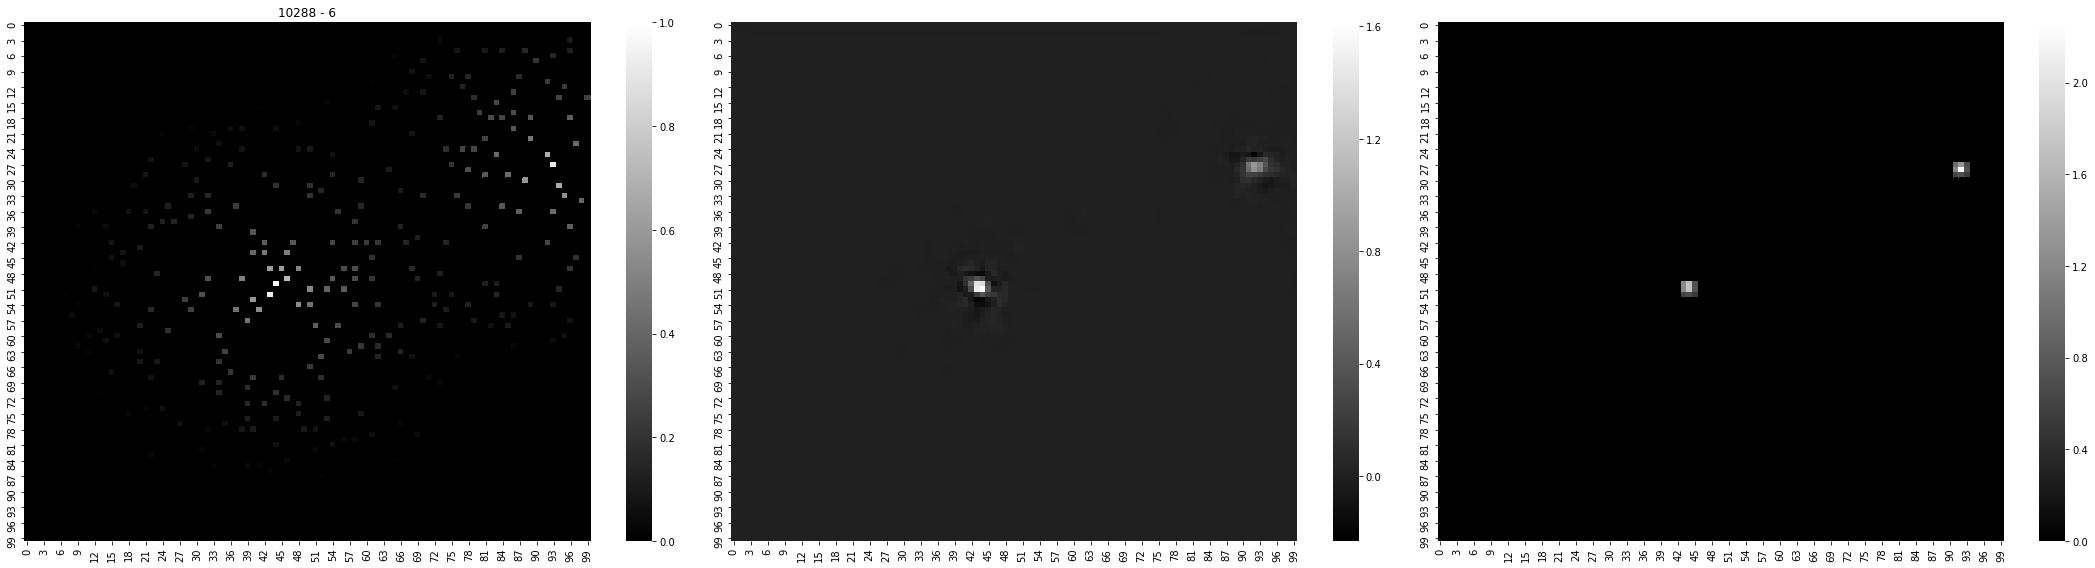

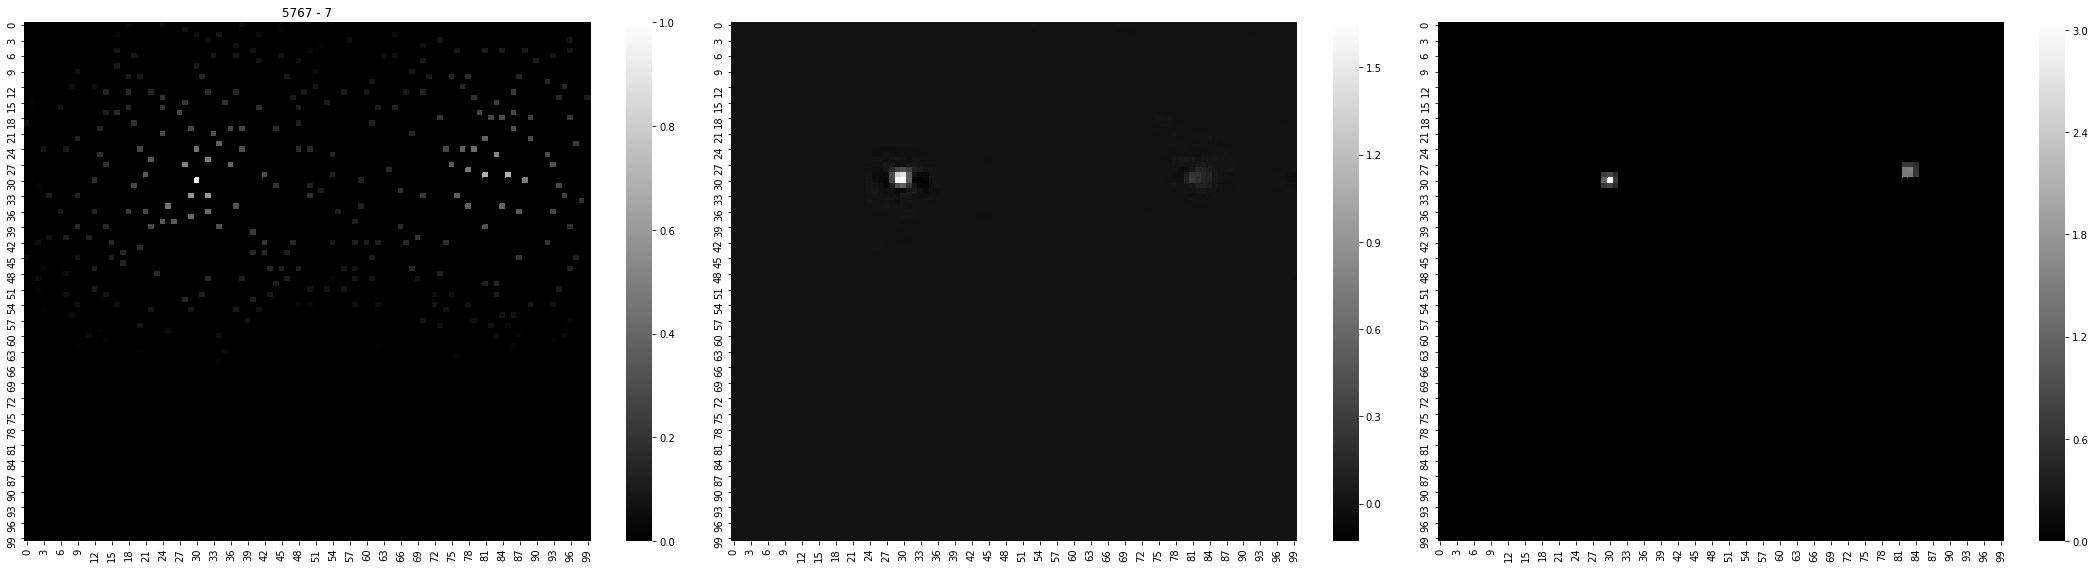

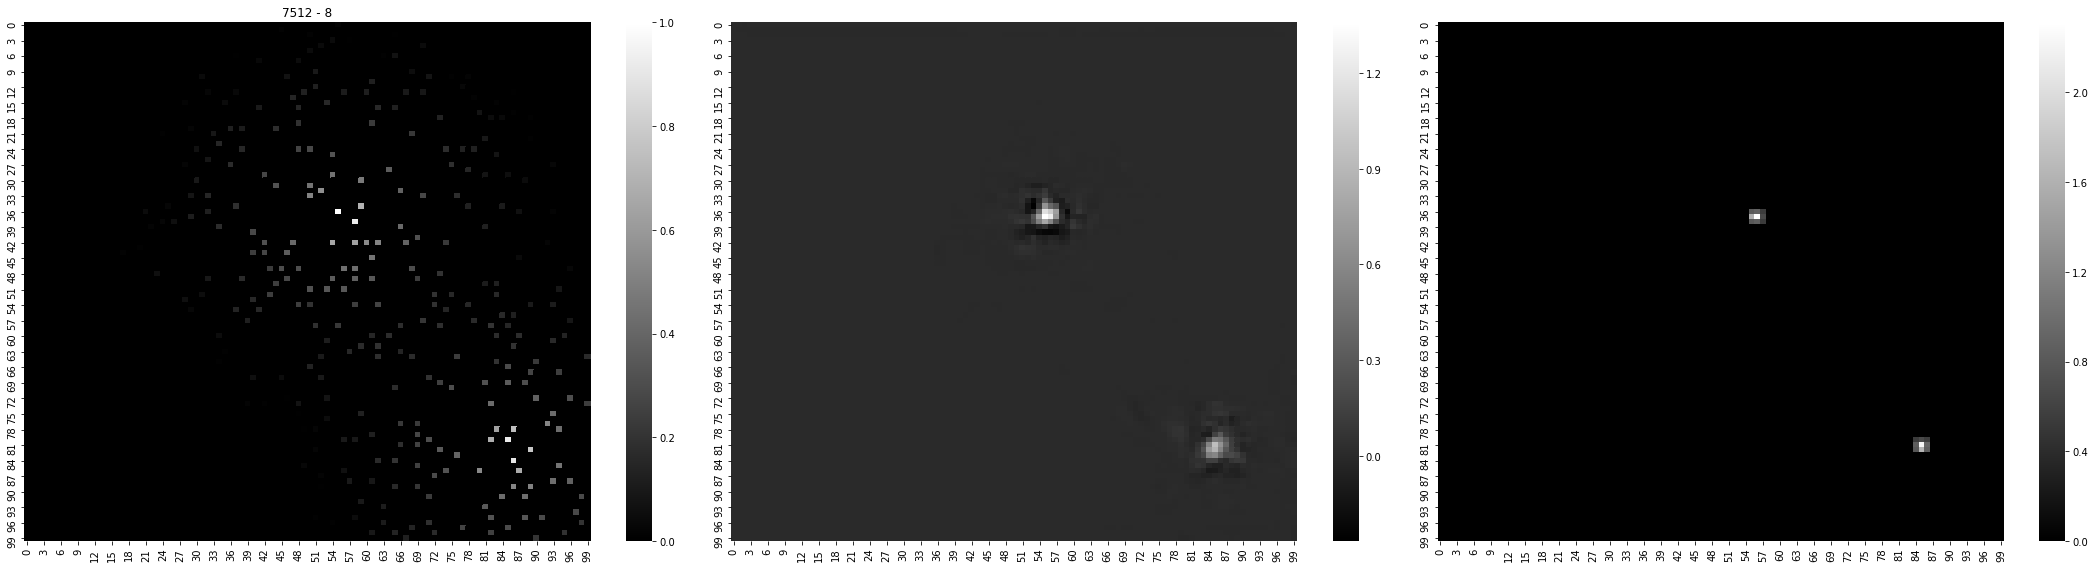

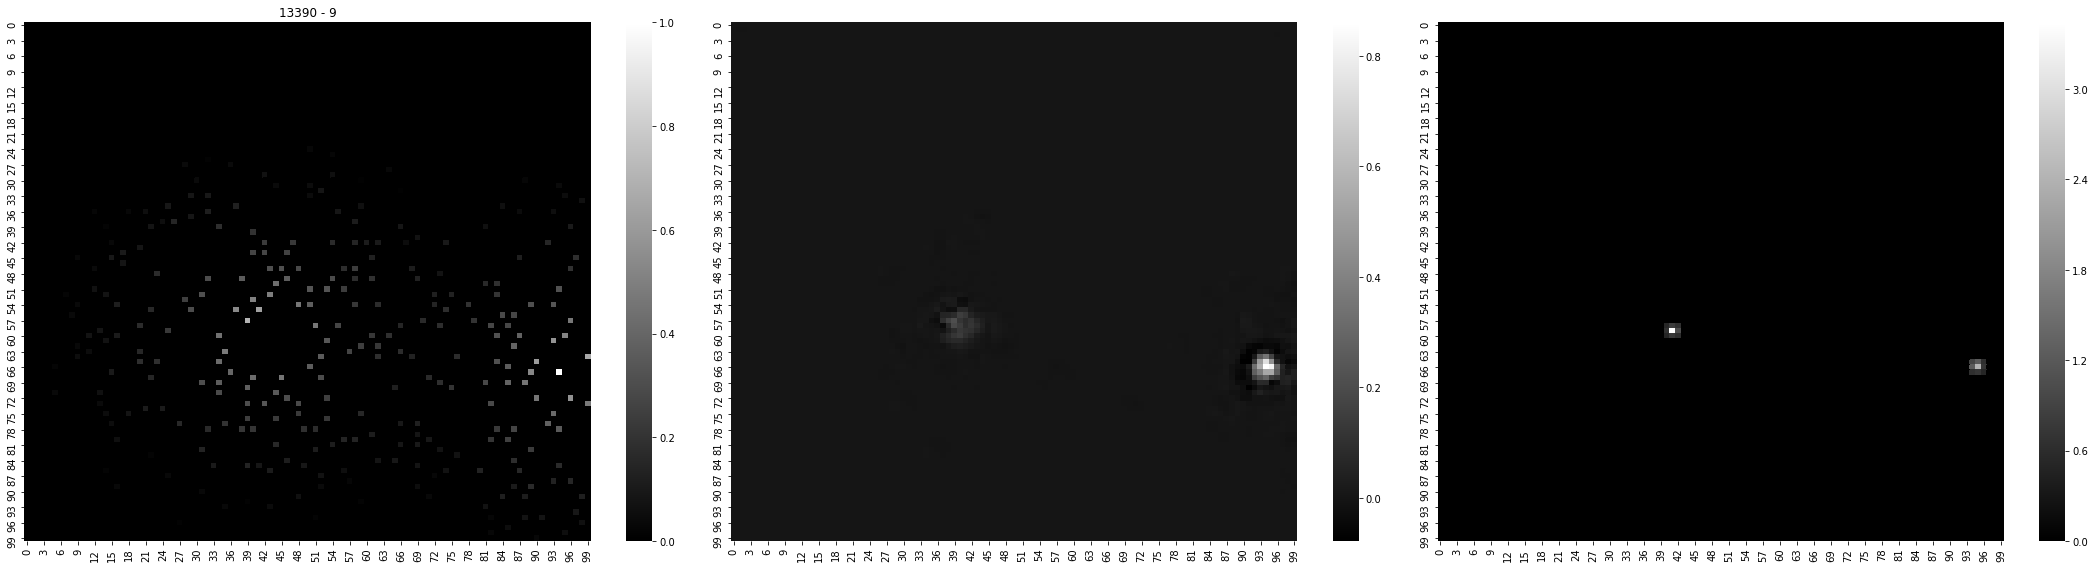

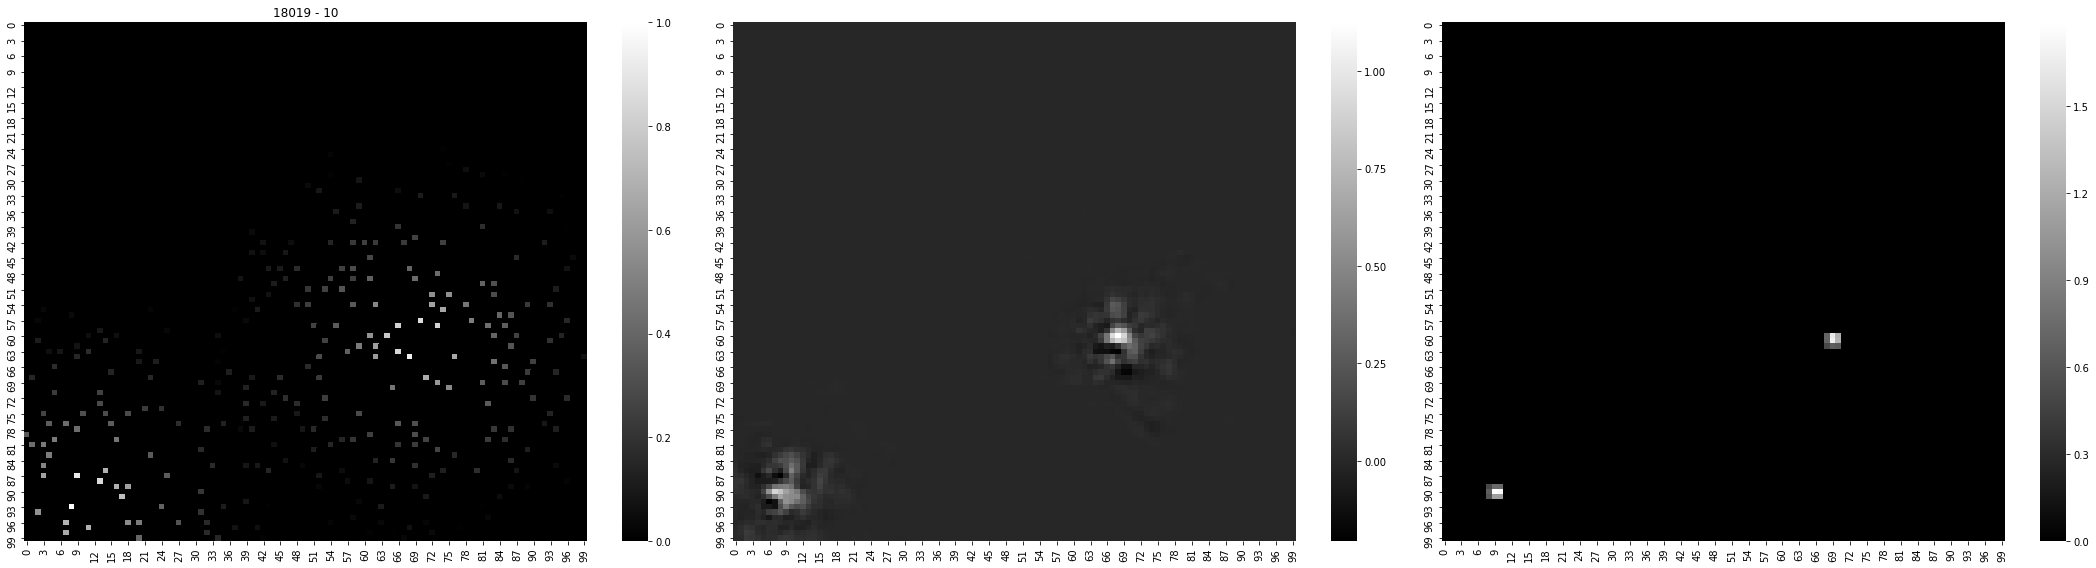

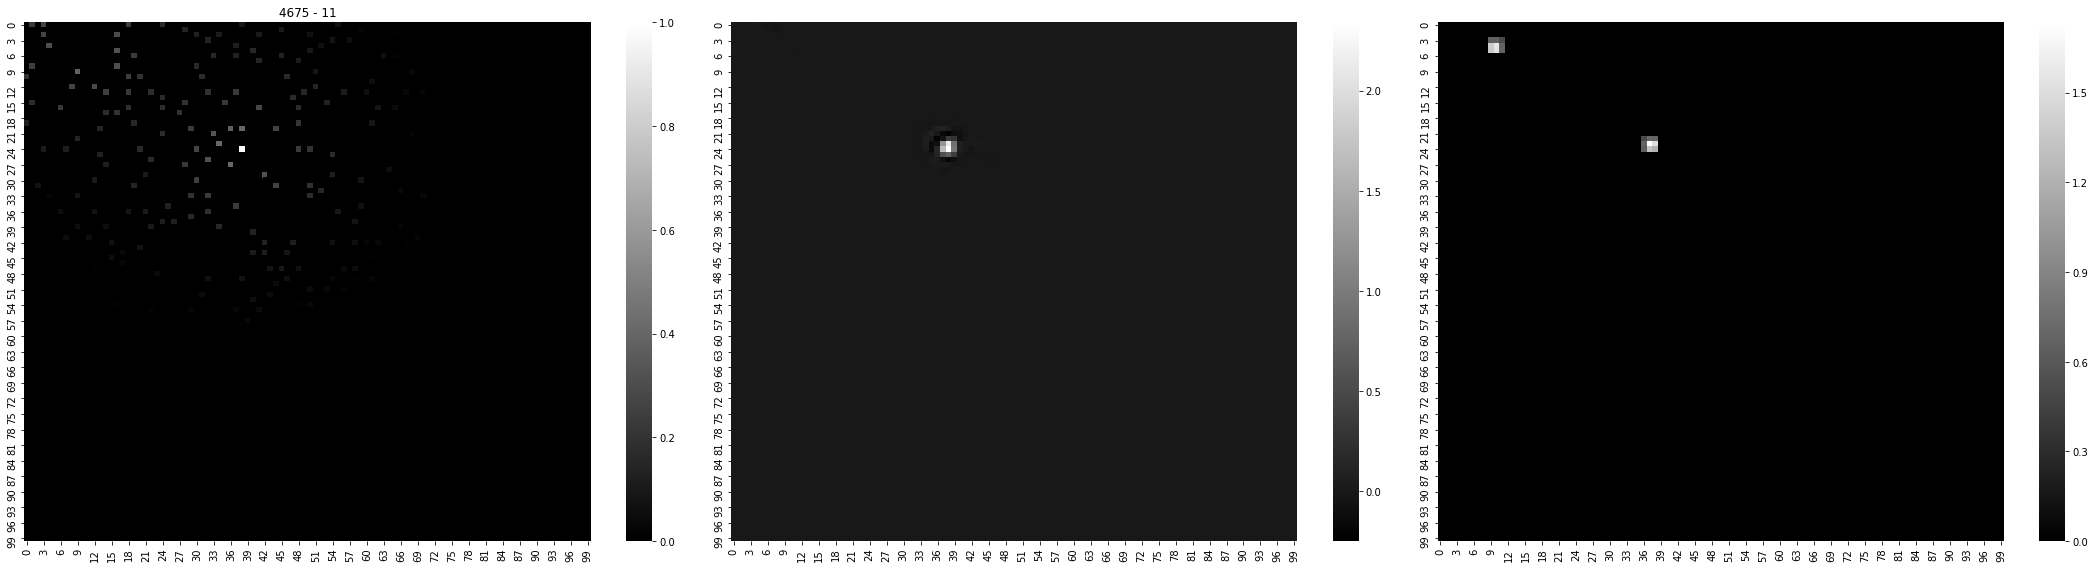

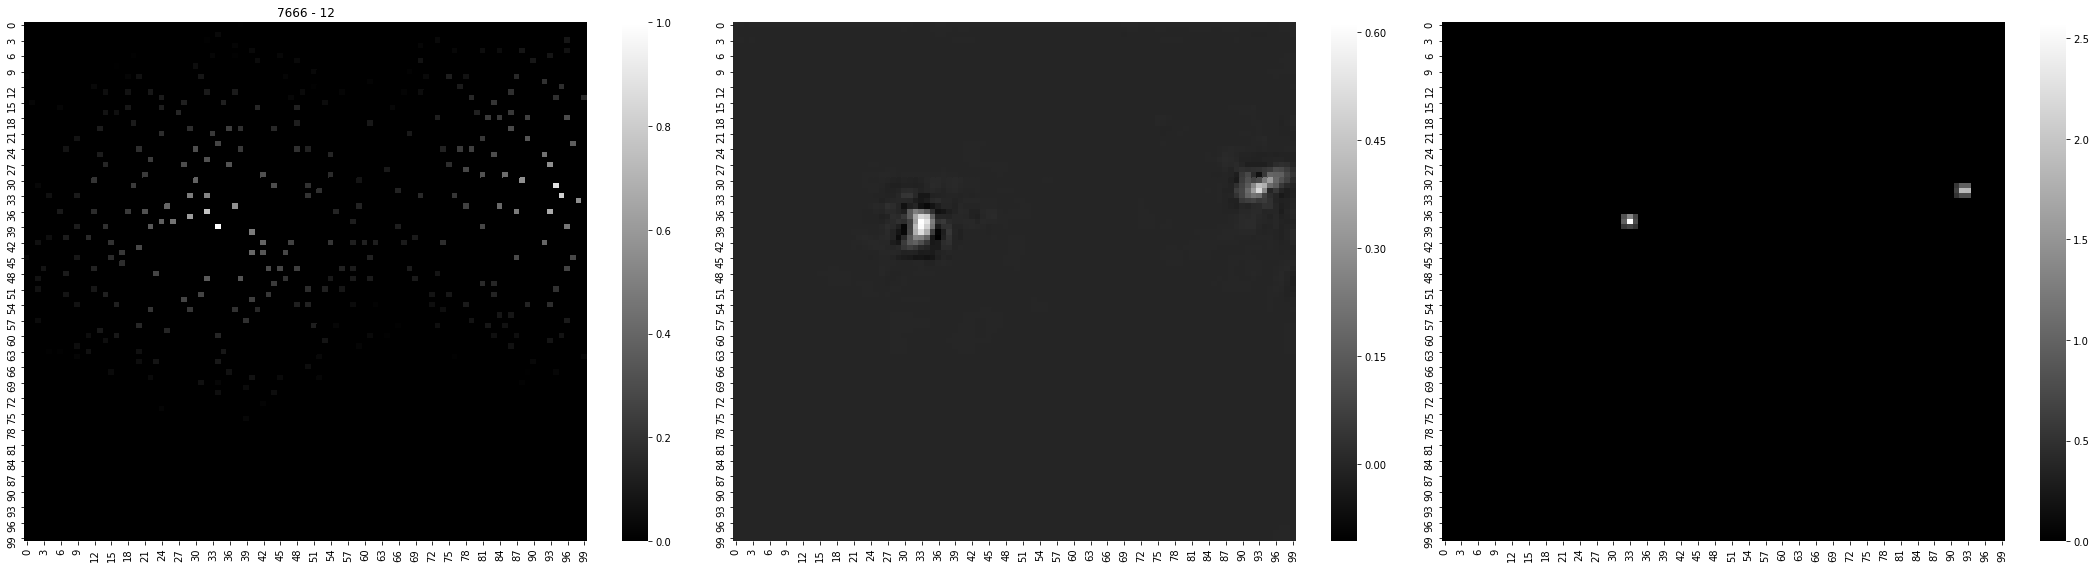

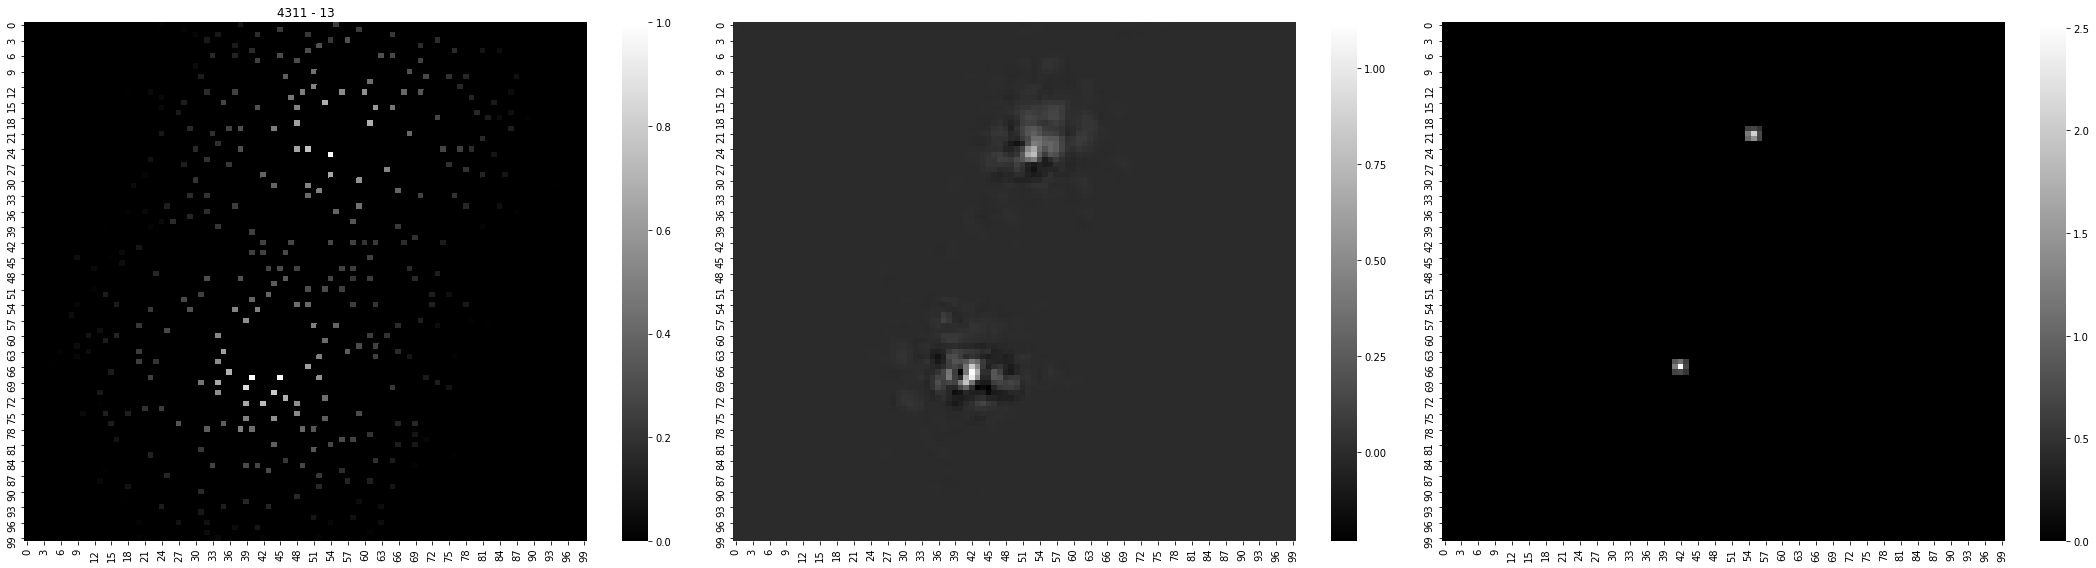

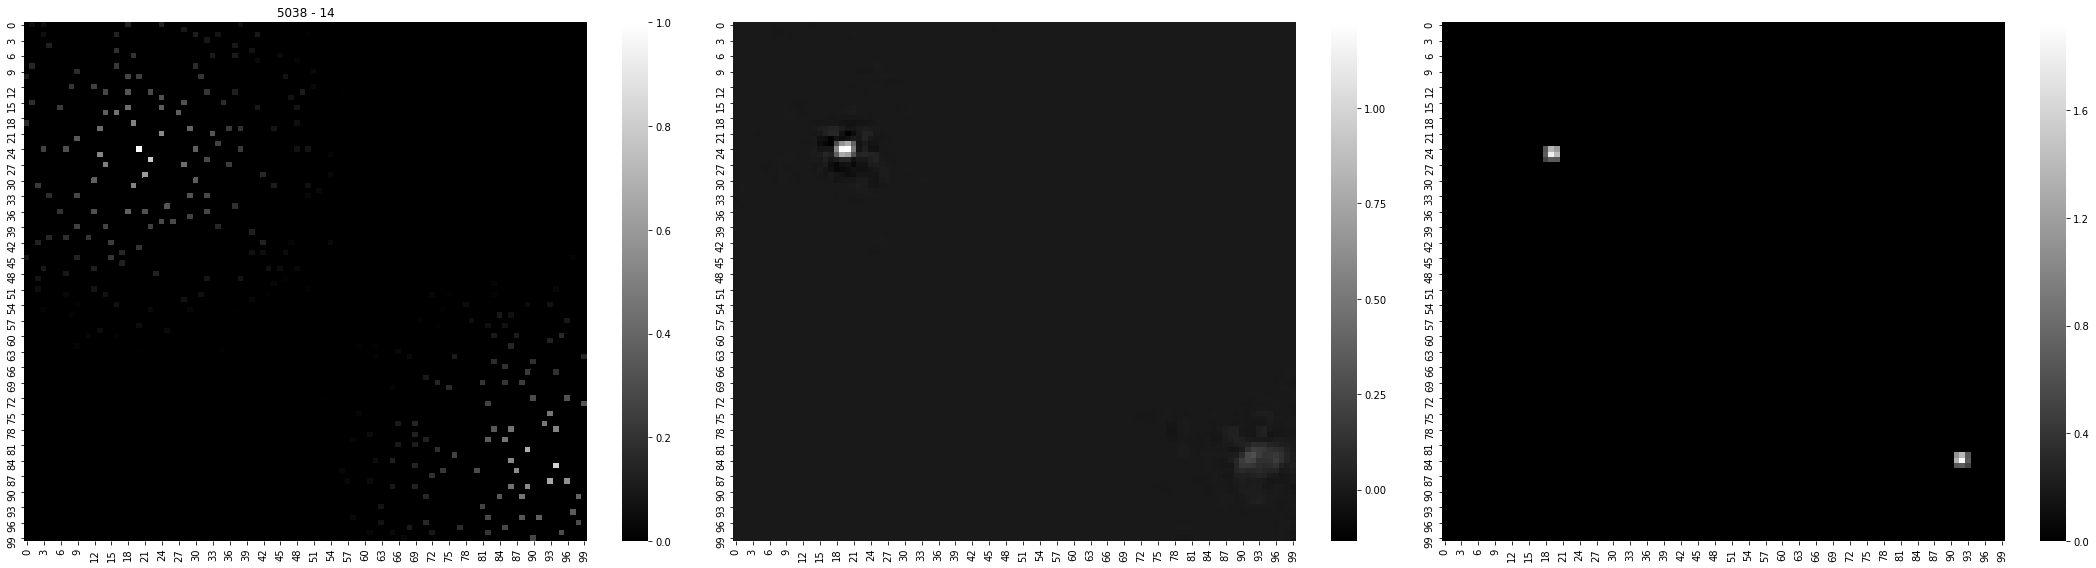

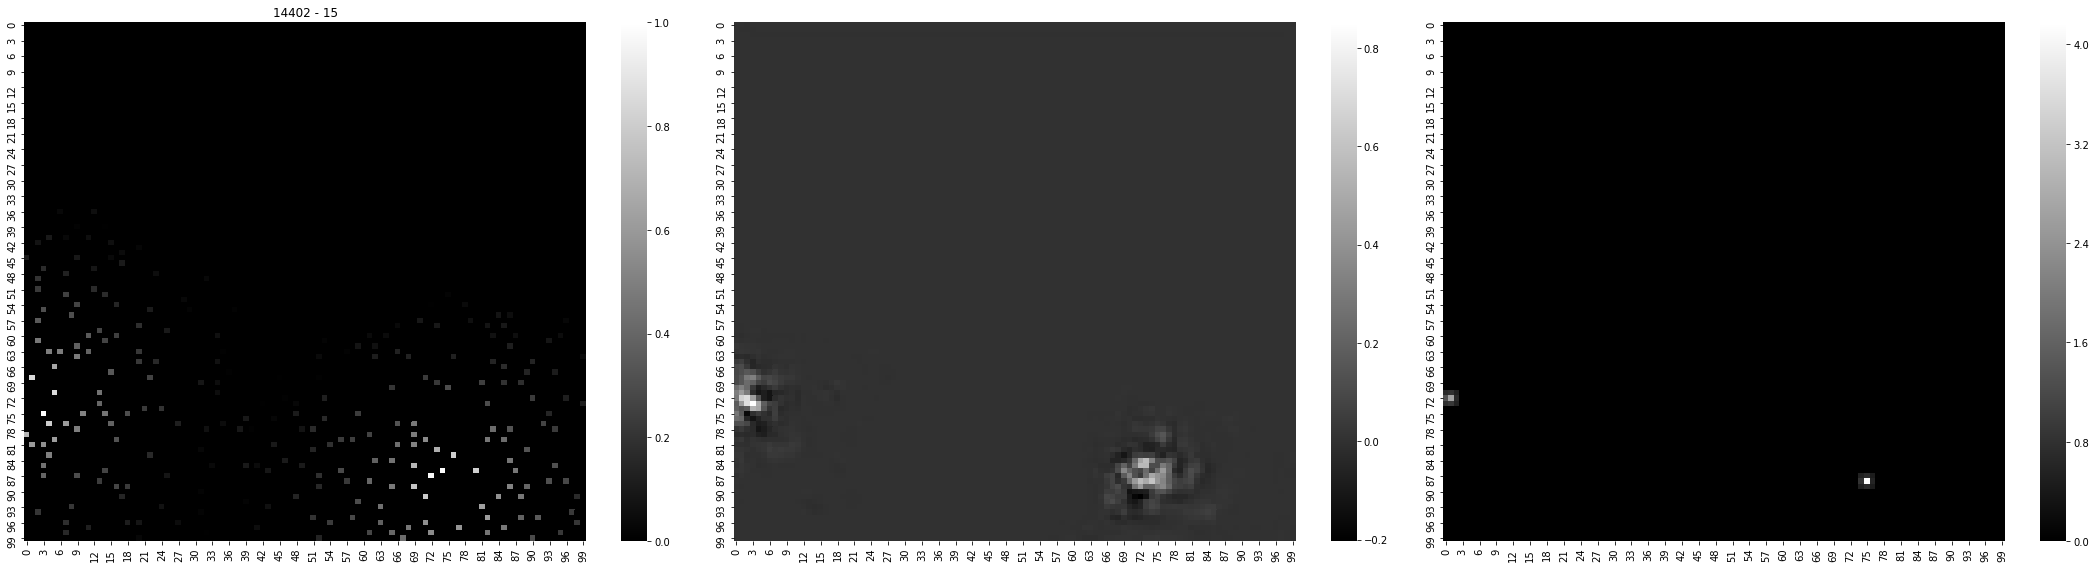

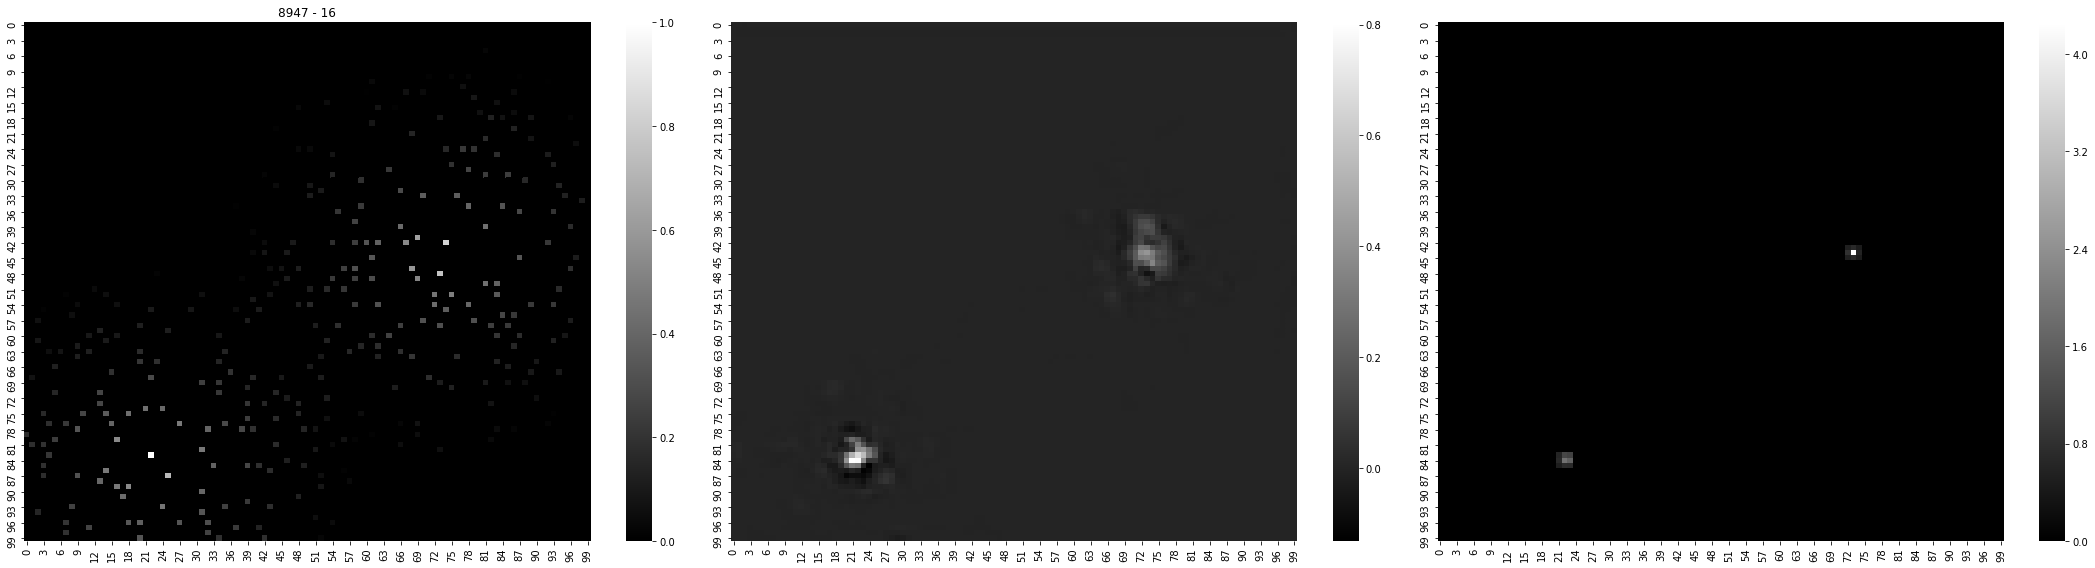

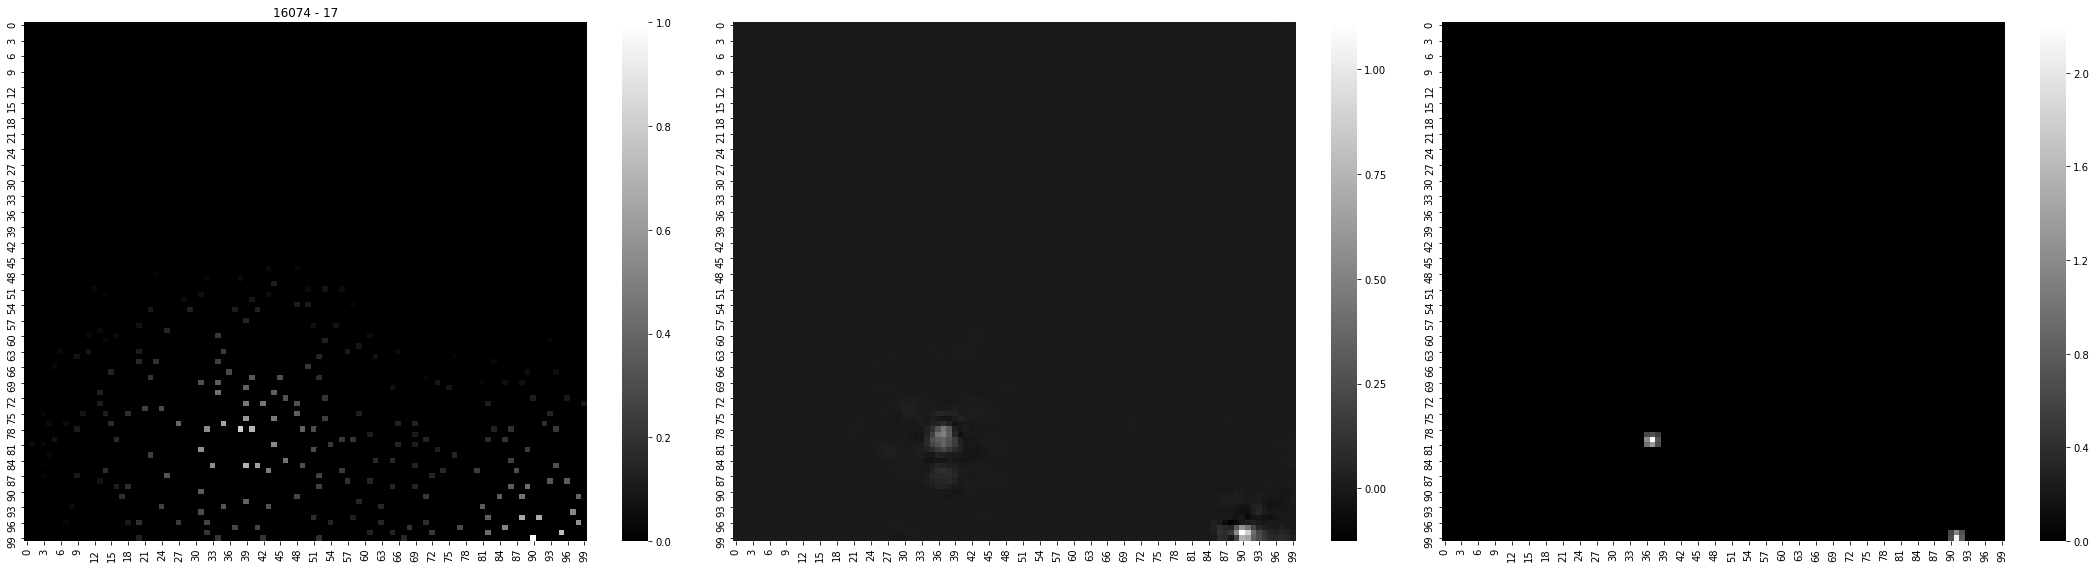

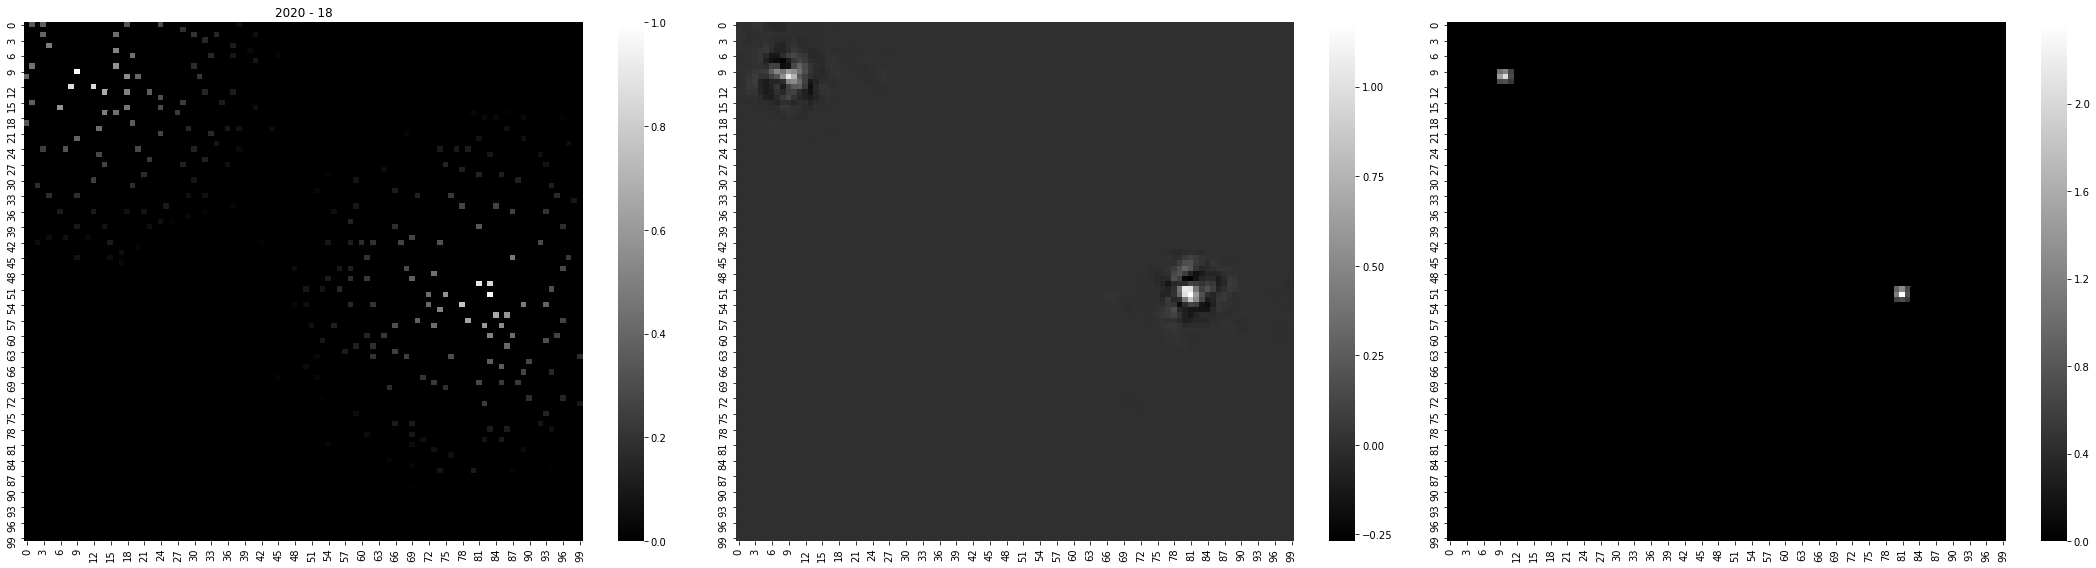

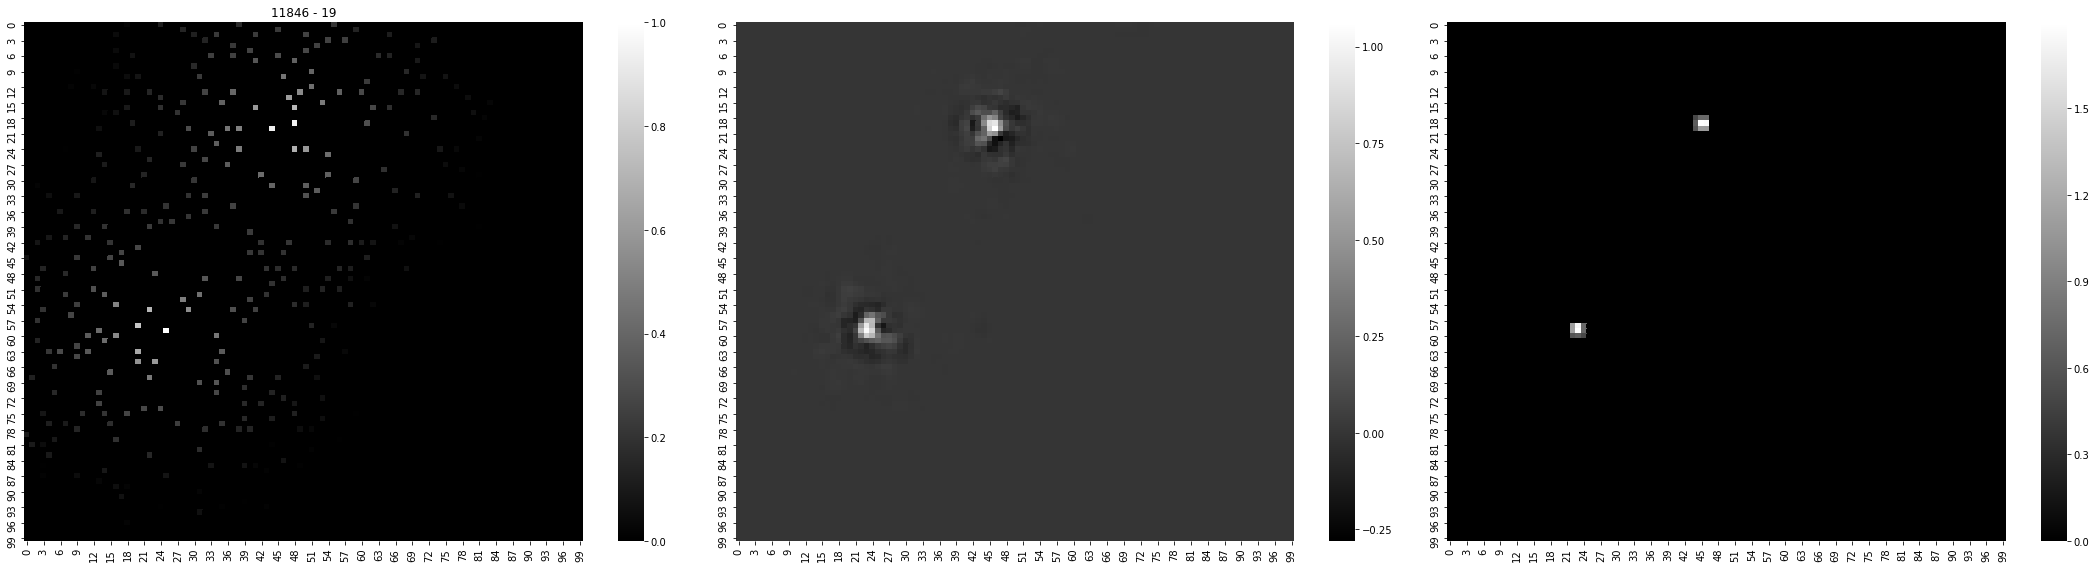

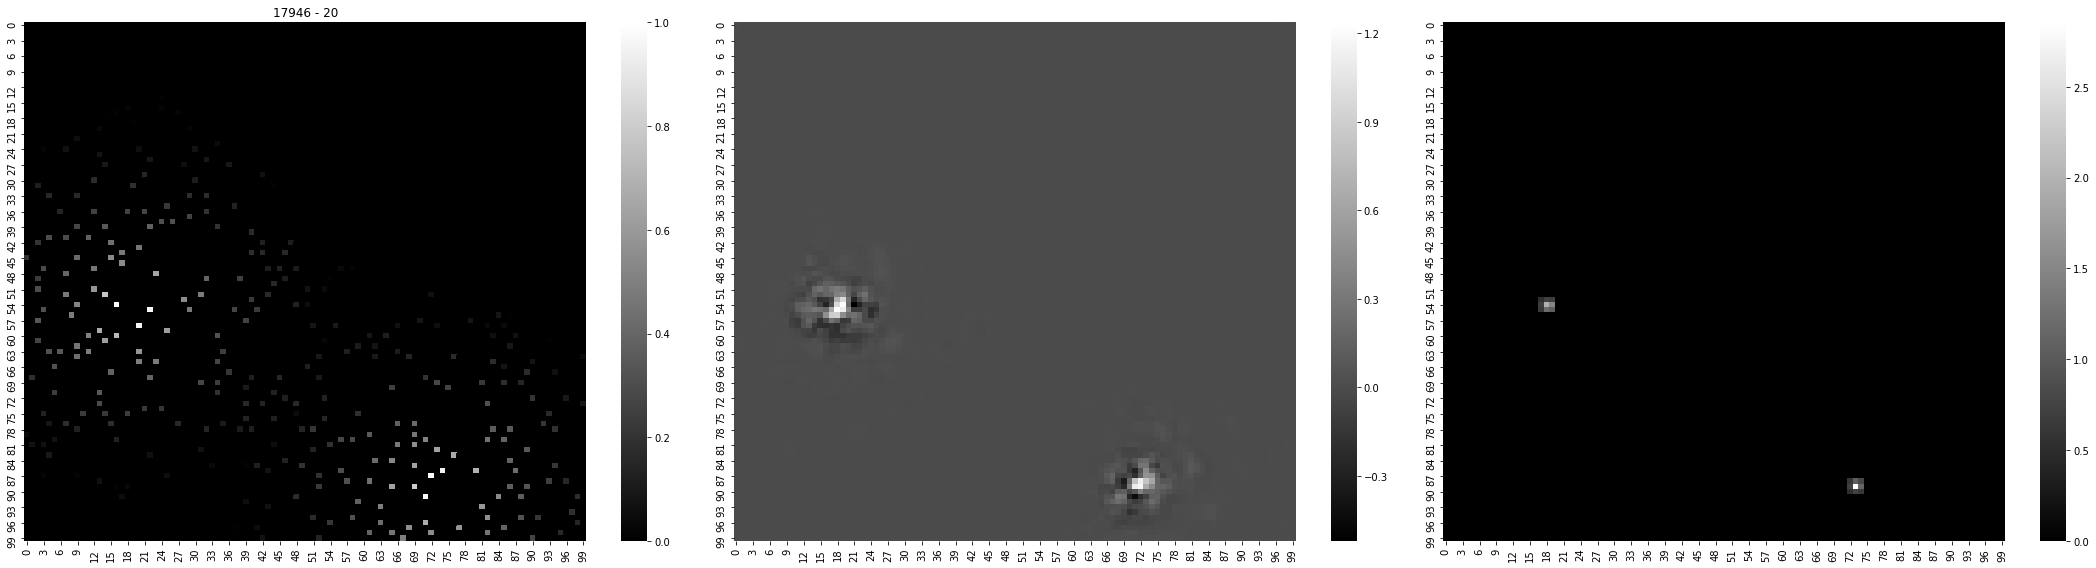

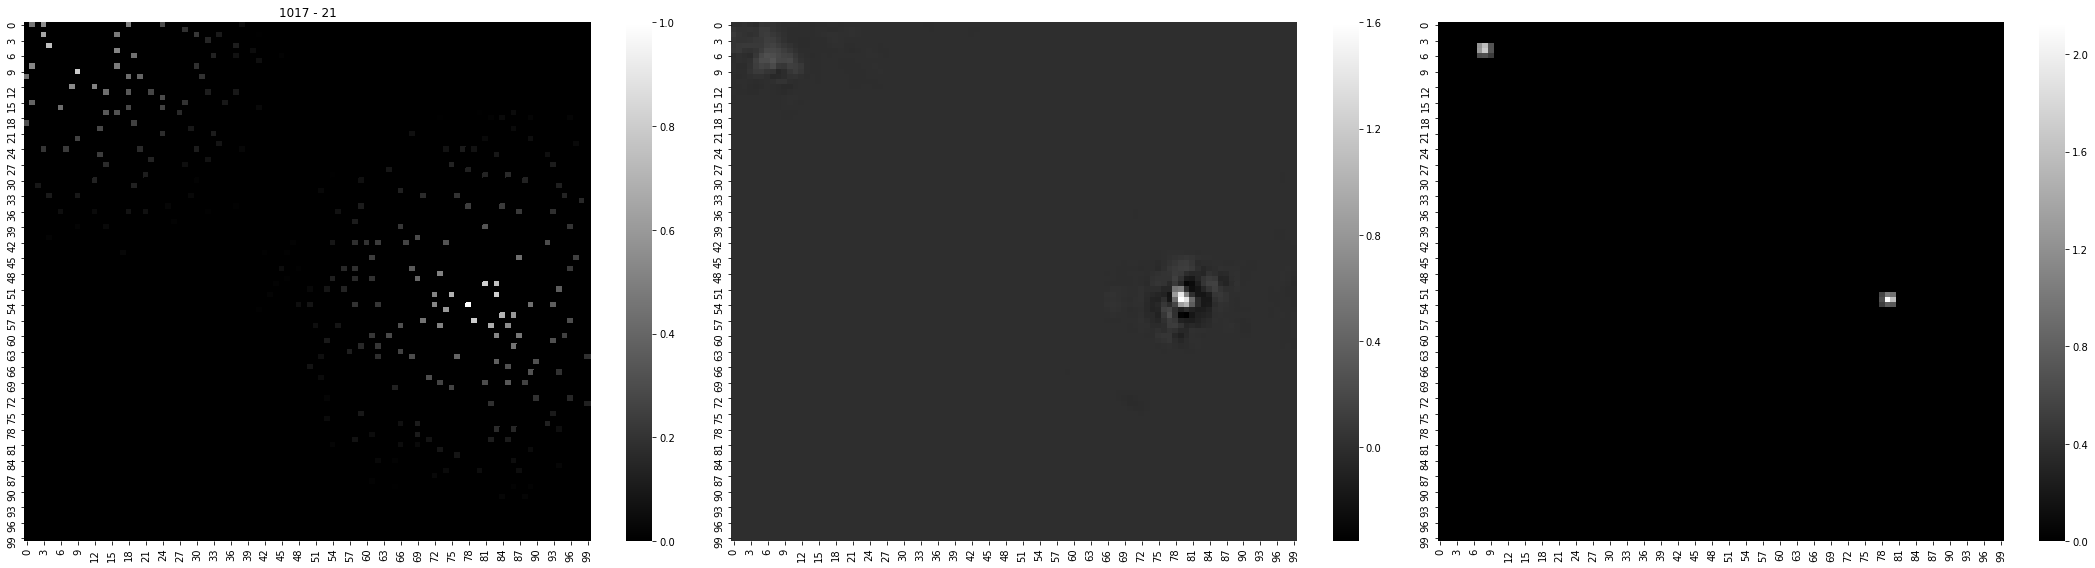

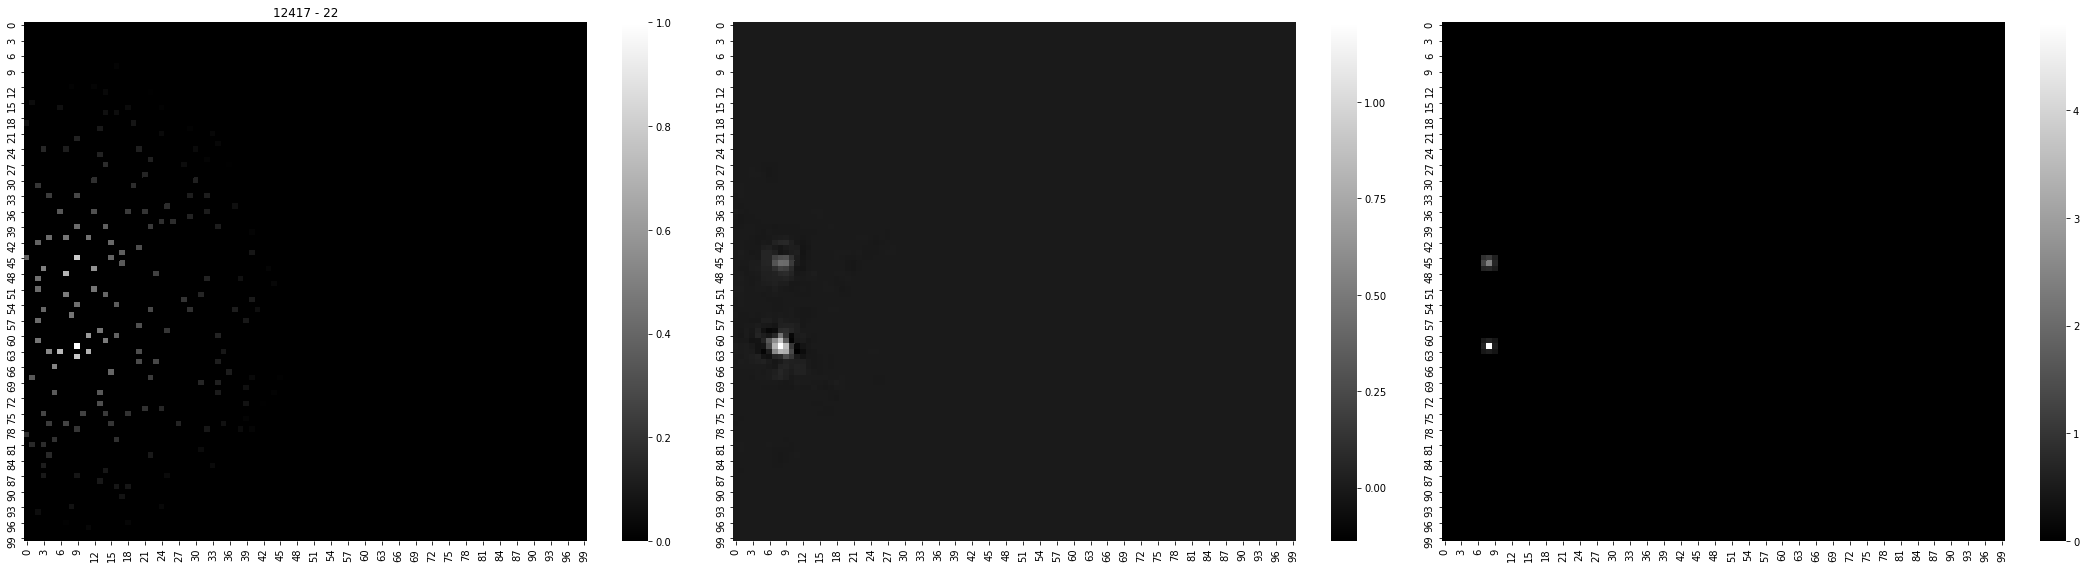

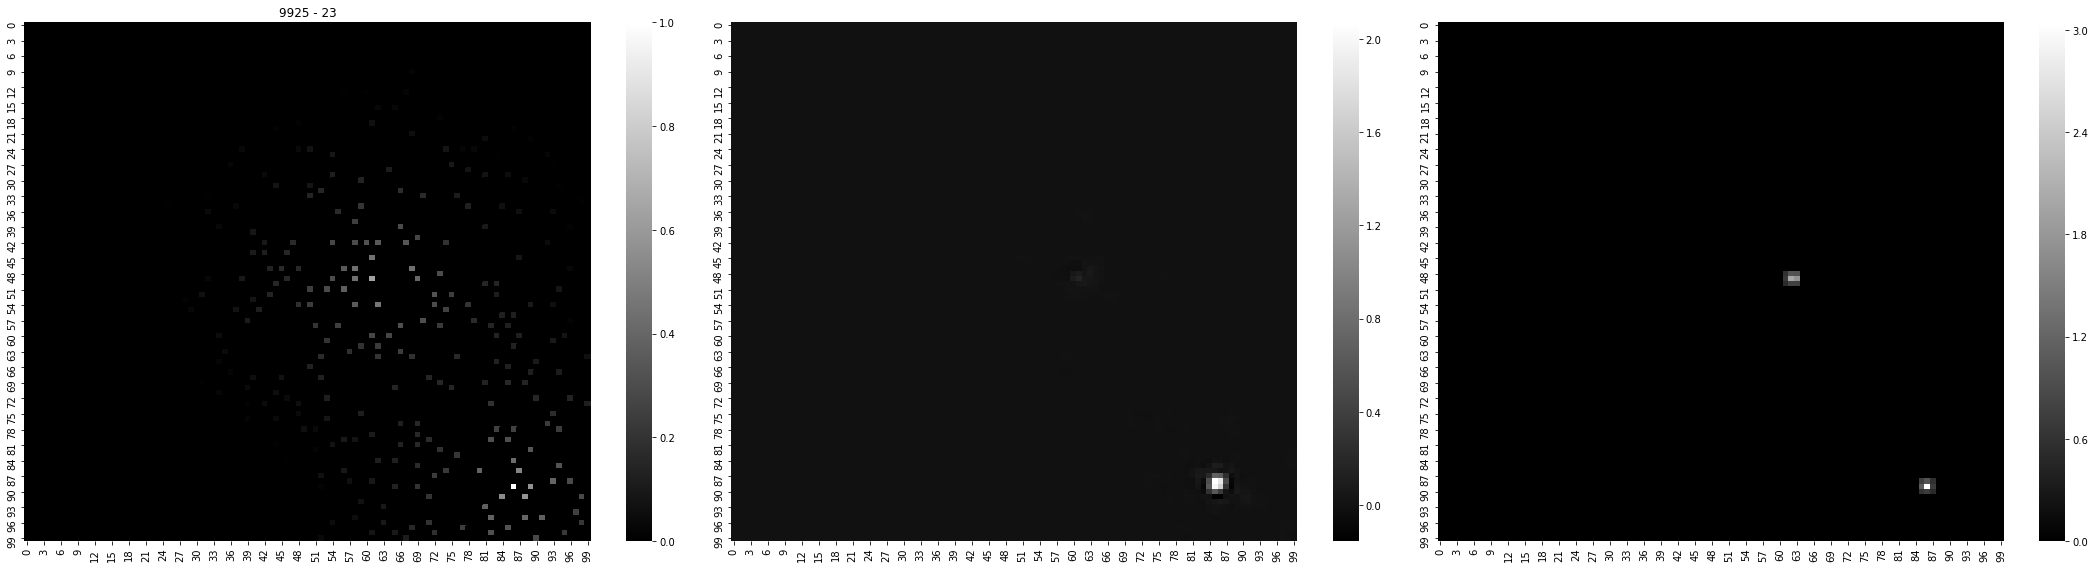

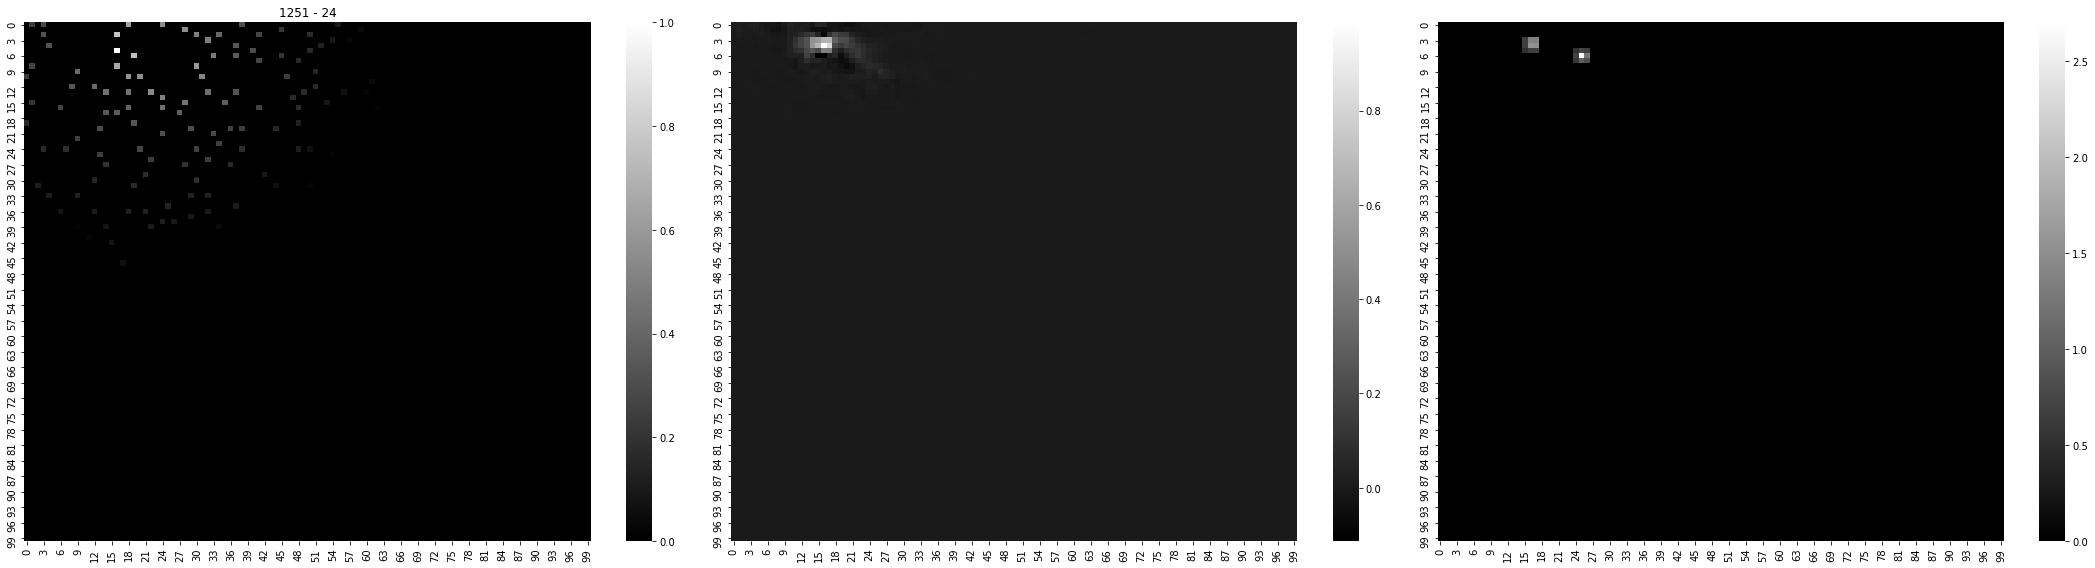

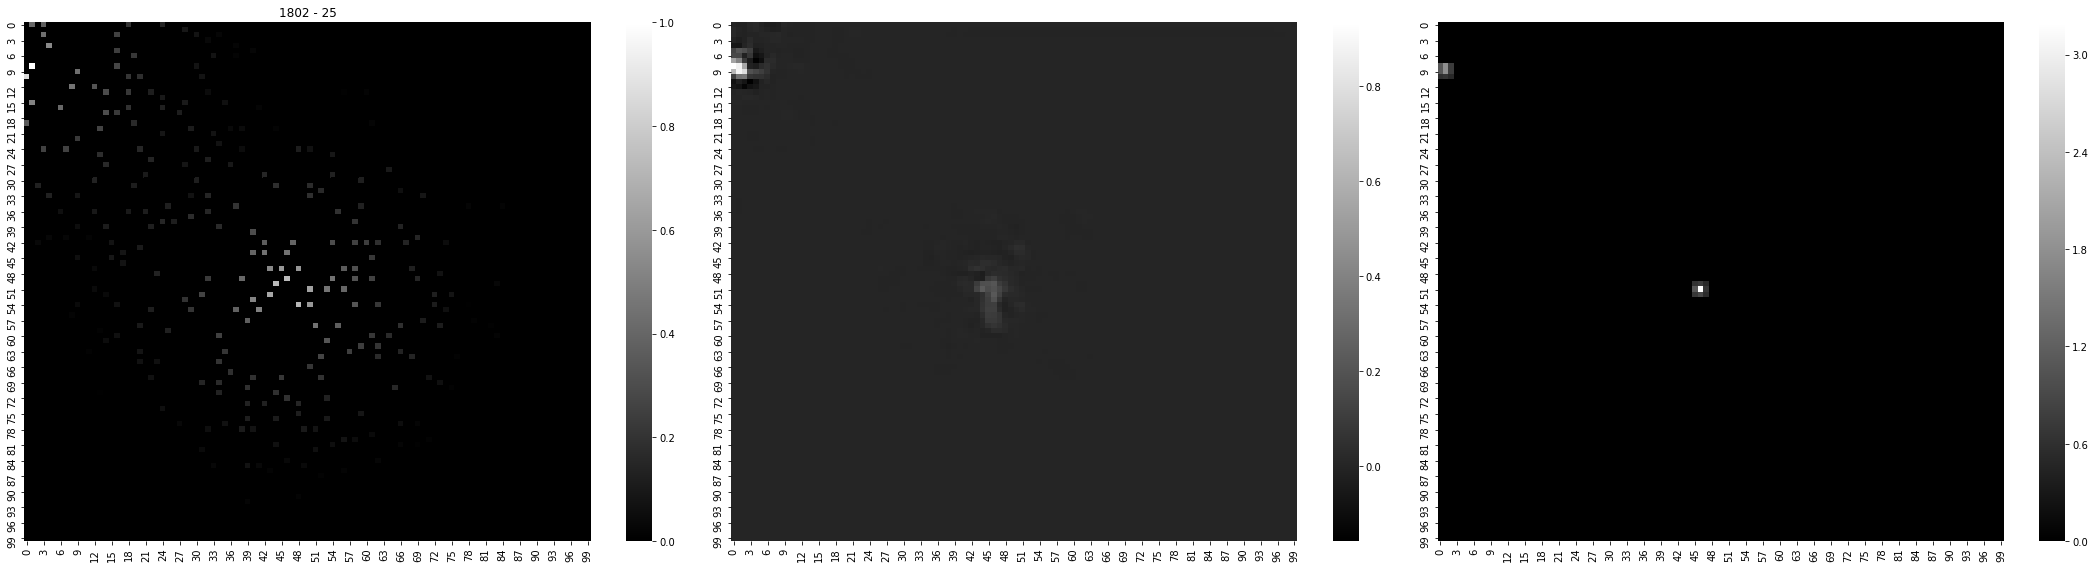

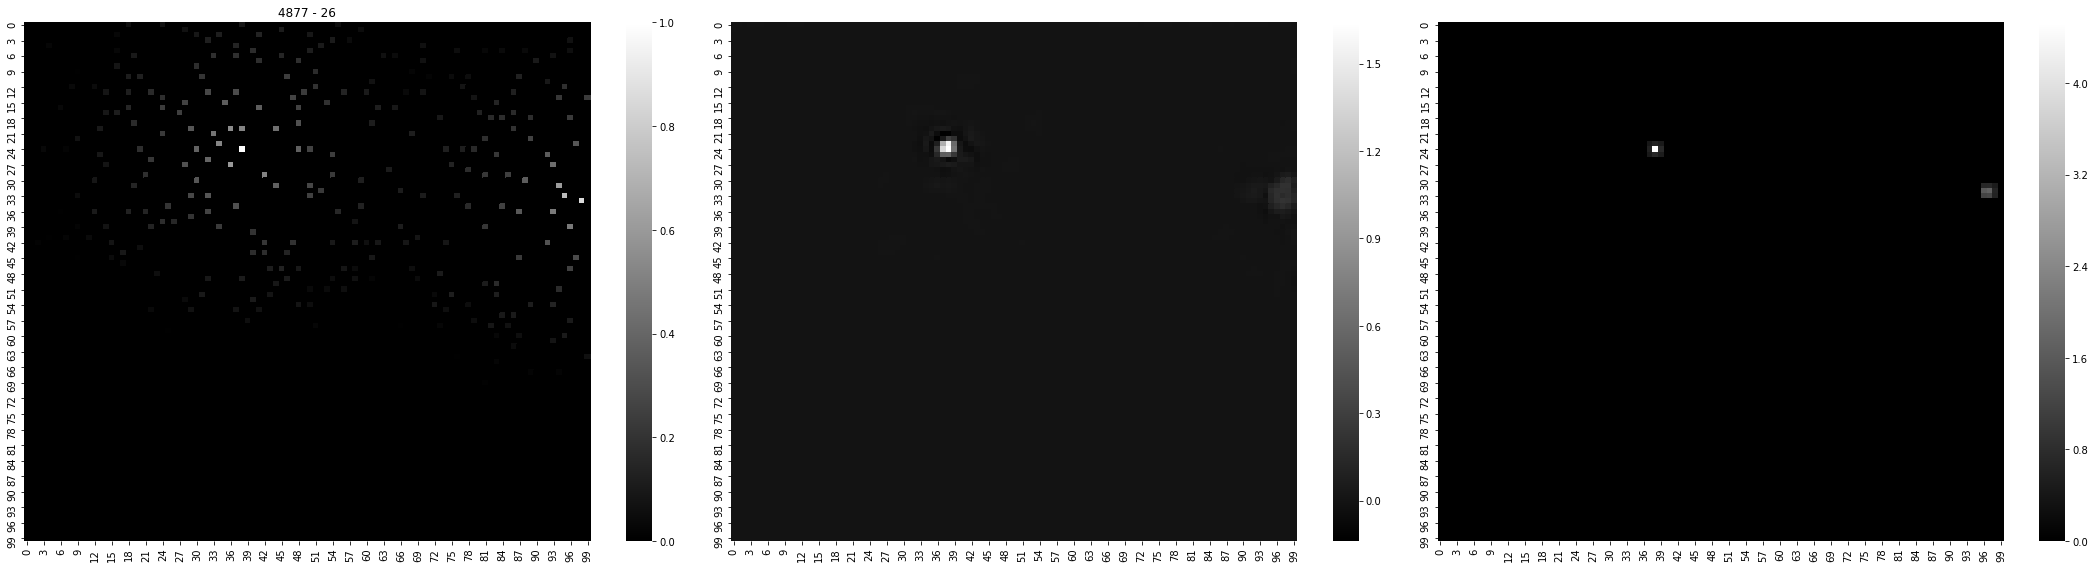

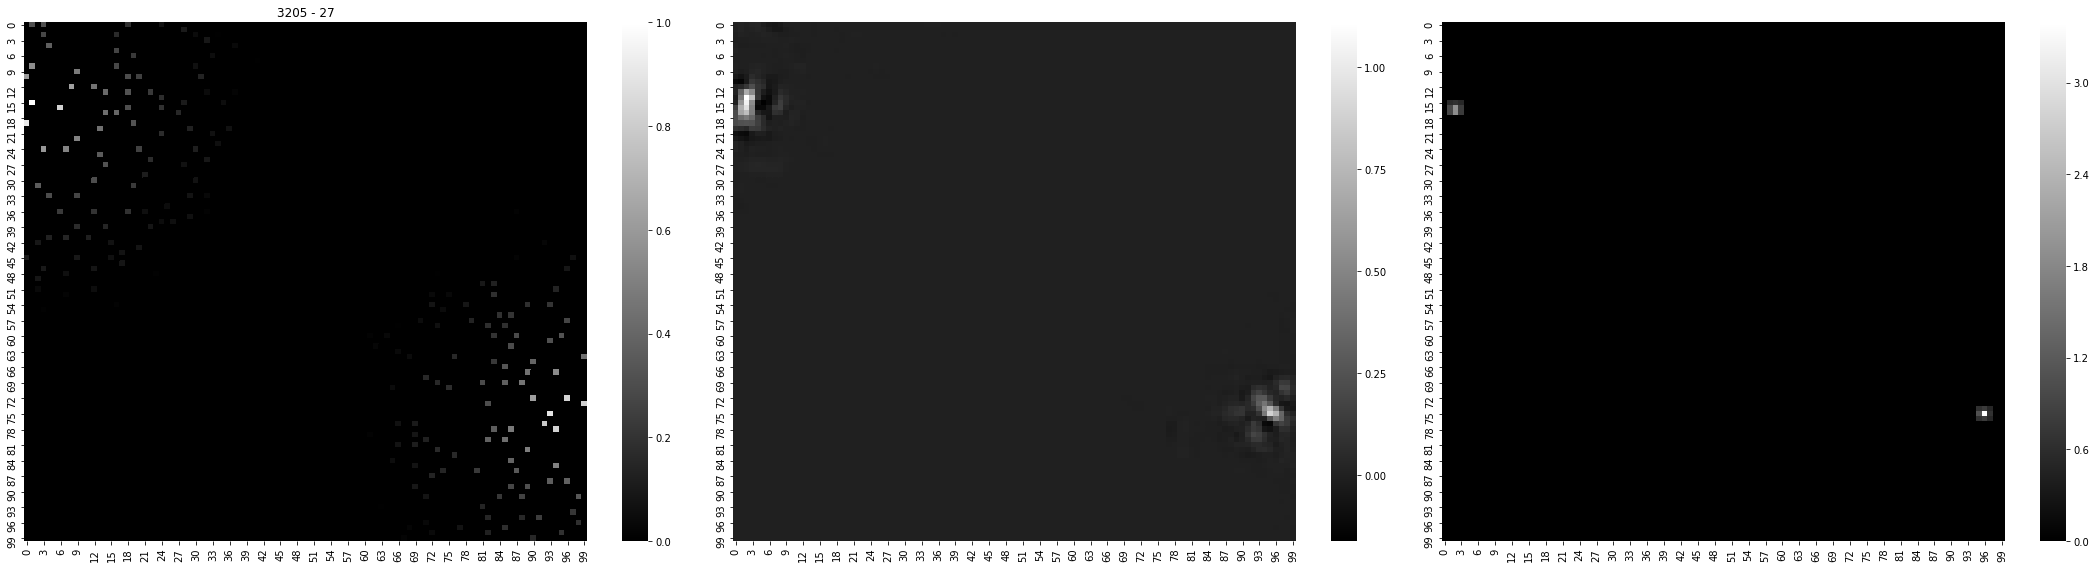

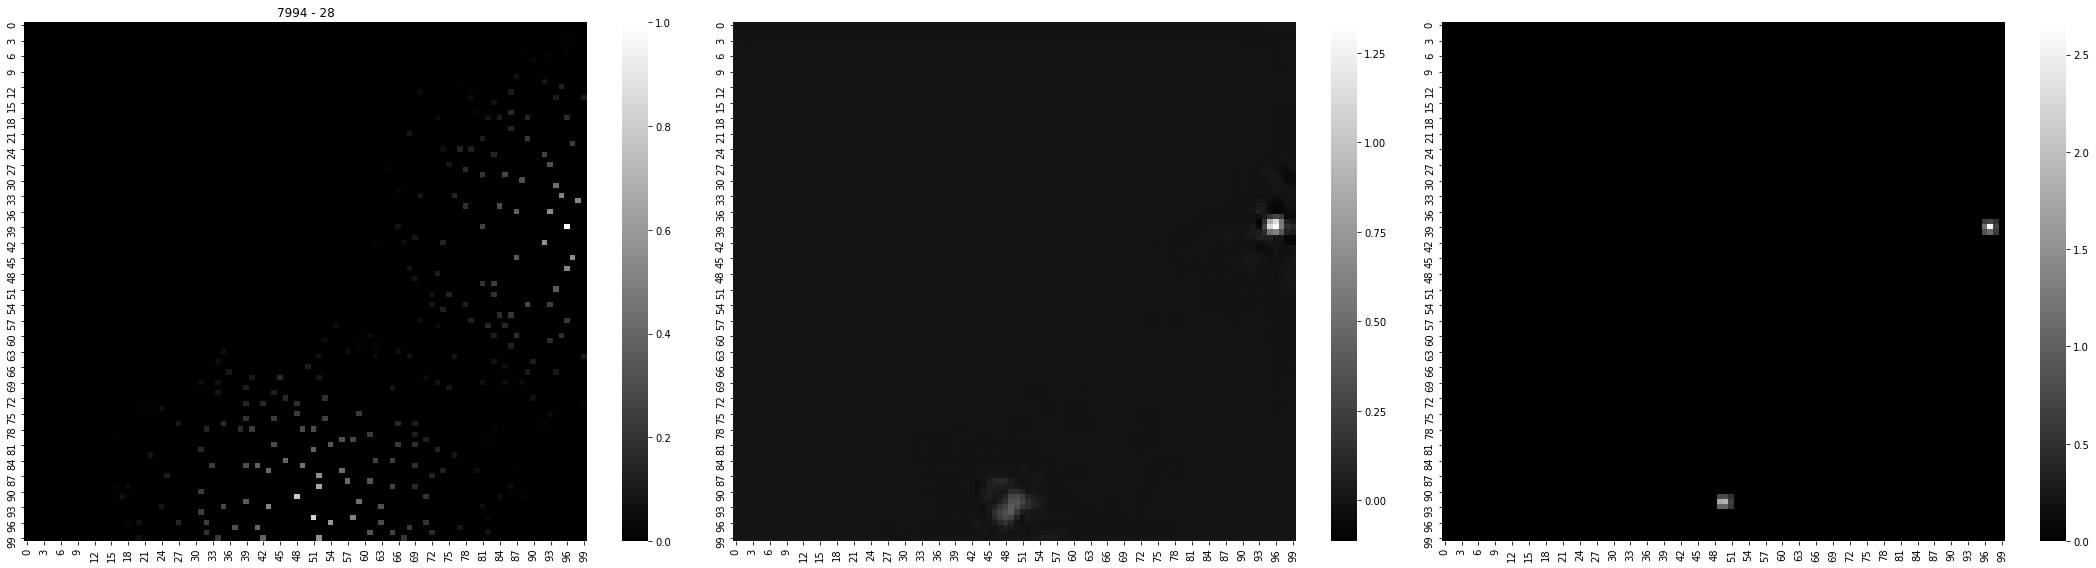

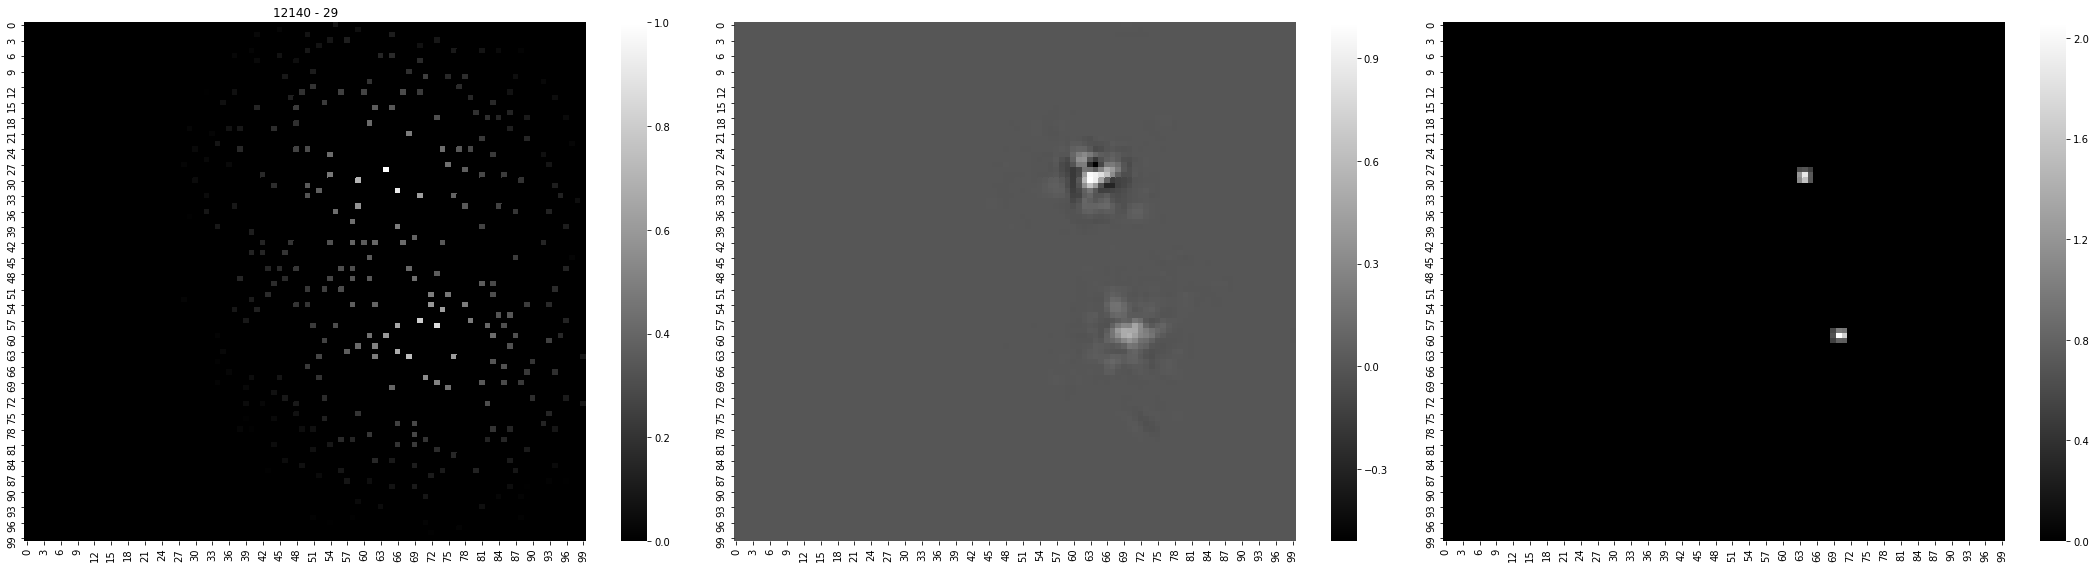

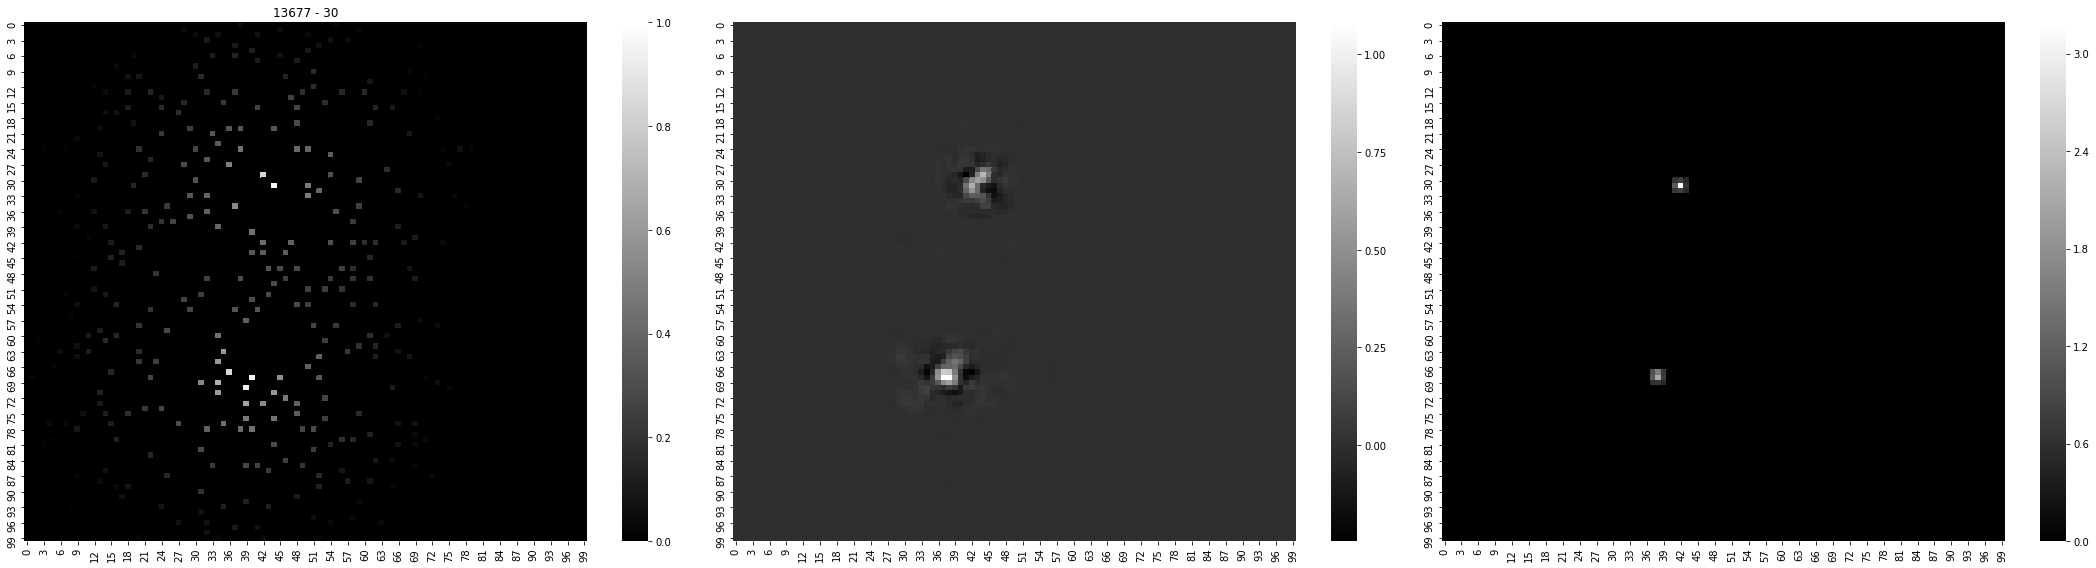

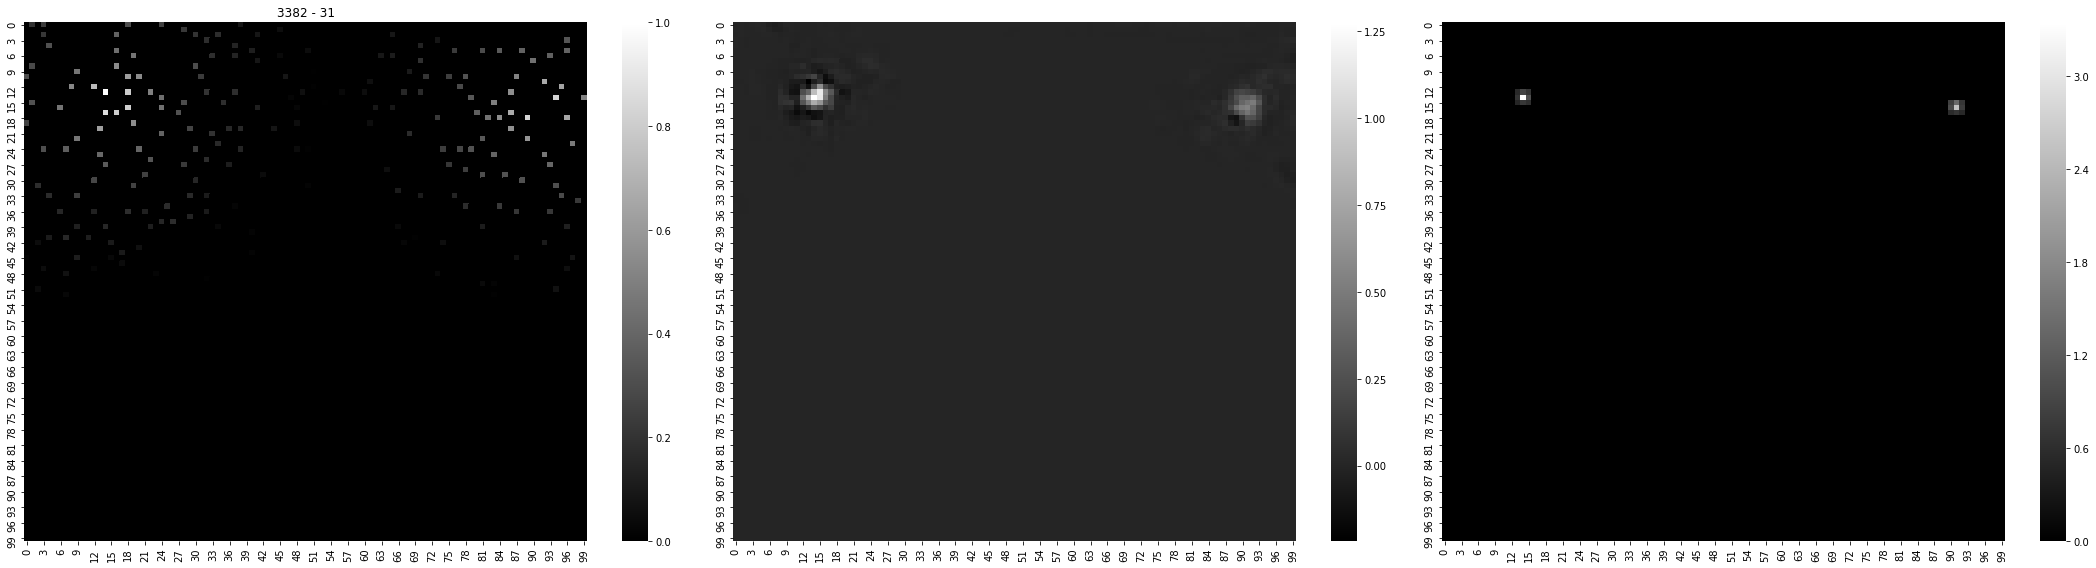

In [47]:
for i in range(len(pred_matrix)):
    myplot(X[i], pred_matrix[i], y[i], indx[i], i)
    print(i, end=' ')

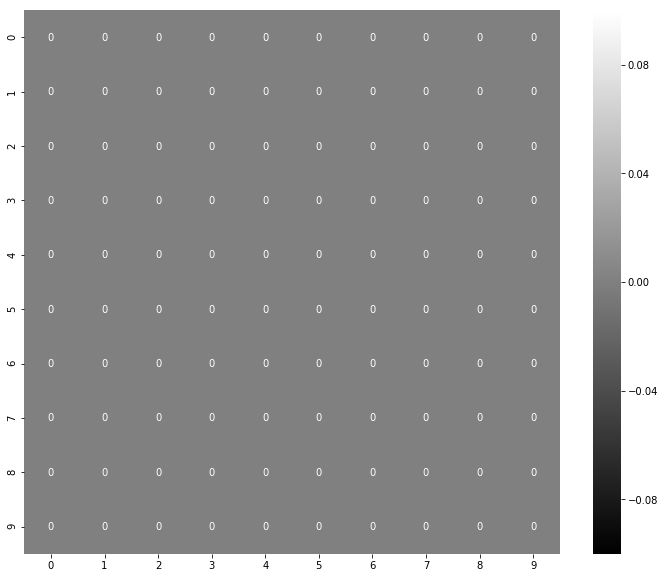

In [74]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(pred_matrix[i, 0][:10,:10], cmap='gray', annot=True)

# Mics

In [42]:
for i in range(32):
    image = pred_matrix[i][0]
    threshold = 0.05
    peaks, size = Peaks.detect(image, 2)

    threshold_mask = image < threshold
    image[threshold_mask] = 0

    neighborhood = np.array([[True for _ in range(size)] for _ in range((size))])

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.
    #we create the mask of the background
    background = (image < 0.05)
    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    print(type(local_max), local_max.shape, type(eroded_background), eroded_background.shape)
    detected_peaks = local_max ^ eroded_background

    fig, axes = plt.subplots(1, 5, figsize=(25, 4.5))
    sns.heatmap(image, cmap='gray', annot=False, ax = axes[0])
    sns.heatmap(local_max, cmap='gray', annot=False, ax = axes[1])
    sns.heatmap(background, cmap='gray', annot=False, ax = axes[2])
    sns.heatmap(eroded_background, cmap='gray', annot=False, ax = axes[3])
    sns.heatmap(detected_peaks, cmap='gray', annot=False, ax = axes[4])
    axes[0].set_title('image {}'.format(i))
    axes[1].set_title('local max')
    axes[2].set_title('back ground')
    axes[3].set_title('eroded background')
    axes[4].set_title('peaks:{}, size:{}'.format(str(peaks), size))
    fig.tight_layout()

NameError: name 'Peaks' is not defined

In [77]:
# def detect(image, num_tx, threshold):
str(Peaks.detect(image, 2))

'[(33, 70), (49, 35)]'

In [11]:
indx = np.where(detected_peaks == True)

NameError: name 'detected_peaks' is not defined

In [60]:
x = indx[0]
y = indx[1]
for i, j in zip(x, y):
    print(i, j)

83 21
97 87


In [48]:
a = np.array([1, 2, 3, 4, 5])
np.where(a == 2)


(array([1]),)